ตรวจสอบว่า PyTorch เห็น GPU:

In [1]:
import torch, platform

print("Python:", platform.python_version())
print("Torch:", torch.__version__)
print("Built with CUDA:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Python: 3.10.18
Torch: 2.8.0+cu129
Built with CUDA: 12.9
CUDA available: True
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


### 1. โหลดโมเดล Vision-Language

- โหลดโมเดล Qwen2.5-VL (Vision-Language model) ที่สามารถเข้าใจ รูปภาพ + ข้อความ
- tokenizer ทำหน้าที่แปลงข้อความเป็นตัวเลข (tokens)
- load_in_4bit=True → ใช้ quantization 4-bit เพื่อลดขนาดโมเดลและประหยัด GPU memory

In [2]:
from unsloth import FastVisionModel
import torch

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit",
    load_in_4bit = True,
    use_gradient_checkpointing = "unsloth",
)

c:\Users\namth\anaconda3\envs\lung_lora\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


W1006 00:56:59.847000 12740 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.9.11: Fast Qwen2_5_Vl patching. Transformers: 4.56.2.
   \\   /|    NVIDIA GeForce RTX 4050 Laptop GPU. Num GPUs = 1. Max memory: 5.997 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.8.0+cu129. CUDA: 8.9. CUDA Toolkit: 12.9. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


### 2. เพิ่ม LoRA (Low-Rank Adaptation)

- ใช้ LoRA (Low-Rank Adaptation) เพื่อ fine-tune โมเดลเฉพาะบางพารามิเตอร์ แทนที่จะ train ใหม่ทั้งหมด
- เราสามารถเลือกว่าจะฝึกเฉพาะ vision part หรือ language part ของโมเดลได้

In [11]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

### 3. โหลด Dataset

- กัน train&eval 85% ไว้ก่อน แล้วทำ 5-Fold บนชุดฝึก เพื่อที่จะได้มี 15% ไว้เป็น blind test สำหรับรายงานผลสุดท้าย
- ใช้ 5-Fold บน train_hf (85%) เพื่อจูน/เลือก hyperparams อย่างยุติธรรม
- หลังได้ค่าตั้งที่ดีที่สุด → เทรนใหม่บน train_hf ∪ val_hf (85%) แล้ววัดบน test_hf

In [4]:
from datasets import load_from_disk

hf = load_from_disk("lung8_image_text")

print(hf)
print(hf.features)

Dataset({
    features: ['image', 'text', '__class__'],
    num_rows: 6085
})
{'image': Image(mode=None, decode=True), 'text': Value('string'), '__class__': Value('string')}


แบ่ง dataset hf ออกเป็น 85% สำหรับ train และ 15% สำหรับ blind test

In [5]:
splits = hf.train_test_split(test_size=0.15, seed=42, shuffle=True)

train_hf = splits["train"]
blind_test_hf = splits["test"]       # blind test

# แสดงขนาดของแต่ละชุด
print(f"Total dataset size : {len(hf):,}")
print(f"Train set size     : {len(train_hf):,} ({len(train_hf)/len(hf)*100:.2f}%)")
print(f"Test set size      : {len(blind_test_hf):,} ({len(blind_test_hf)/len(hf)*100:.2f}%)")

Total dataset size : 6,085
Train set size     : 5,172 (85.00%)
Test set size      : 913 (15.00%)


ดังนั้นจำนวน K ที่ “ลงตัวเป๊ะ” (ขนาดแต่ละ fold เท่ากันพอดี) คือ:

K = 2 → 2,586/fold

K = 3 → 1,724/fold

K = 4 → 1,293/fold

K = 6 → 862/fold ← แนะนำ (ใกล้กับมาตรฐาน, granularity ดี, ภาระคอมพิวต์พอเหมาะ)

แปลว่าเราจะแบ่ง train_hf เป็น 6 ส่วนเท่ากัน แล้ว รวม 5 ส่วนแรกเข้าด้วยกัน เพื่อใช้เทรนโมเดล
=> 1 ส่วนที่เหลือจะกลายเป็น val data ต่อไป

In [6]:
n = len(train_hf)
k = 6
fold_size = n // k

folds = []
for i in range(k):
    start = i * fold_size
    end = (i + 1) * fold_size if i < k - 1 else n
    fold = train_hf.select(range(start, end))
    folds.append(fold)

# เลือก fold ที่ต้องการรวม (เช่น 0-4)
# selected_folds = [1, 2, 3, 4, 5]        # ← แก้เลขใน list นี้ได้ตามต้องการ
# selected_folds = [0, 2, 3, 4, 5]        # ← แก้เลขใน list นี้ได้ตามต้องการ
# selected_folds = [0, 1, 3, 4, 5]        # ← แก้เลขใน list นี้ได้ตามต้องการ
# selected_folds = [0, 1, 2, 4, 5]        # ← แก้เลขใน list นี้ได้ตามต้องการ
# selected_folds = [0, 1, 2, 3, 5]        # ← แก้เลขใน list นี้ได้ตามต้องการ
selected_folds = [0, 1, 2, 3, 4]        # ← แก้เลขใน list นี้ได้ตามต้องการ

from datasets import concatenate_datasets
train_selected = concatenate_datasets([folds[i] for i in selected_folds])
# idx_selected = 0                        # ← แก้เลขในนี้ได้ตามต้องการ
# idx_selected = 1                        # ← แก้เลขในนี้ได้ตามต้องการ
# idx_selected = 2                        # ← แก้เลขในนี้ได้ตามต้องการ
# idx_selected = 3                        # ← แก้เลขในนี้ได้ตามต้องการ
# idx_selected = 4                        # ← แก้เลขในนี้ได้ตามต้องการ
idx_selected = 5                        # ← แก้เลขในนี้ได้ตามต้องการ
val_selected = folds[idx_selected]            

print(f"Total train_hf : {n}")
print(f"Each fold size : {fold_size}")
print(f"Selected folds : {selected_folds}")
print(f"Combined size  : {len(train_selected)}")

Total train_hf : 5172
Each fold size : 862
Selected folds : [0, 1, 2, 3, 4]
Combined size  : 4310


### 4. แปลง Dataset เป็น Conversation Format

- แปลงข้อมูลให้เป็นรูปแบบ Chat (user → assistant)
- user → ส่งภาพ + คำสั่ง
- assistant → ตอบกลับด้วยข้อความ

In [7]:
instruction = "Describe the chest X-ray using precise clinical terms. Identify one main diagnostic category from: Chest_Changes, Degenerative_Infectious, Higher_Density, Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, Normal, or Obstructive."

def convert_to_conversation(sample):
    cls_name = sample["__class__"]
    description = sample["text"]

    answer = f"Class: {cls_name}\nExplanation: {description}"
    
    conversation = [
        {"role": "user", "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        {"role" : "assistant", "content" : [
            {"type" : "text", "text" : answer} ]
        },
    ]
    
    return {"messages" : conversation}

converted_dataset = [convert_to_conversation(sample) for sample in train_selected]

converted_dataset_val = [convert_to_conversation(sample) for sample in val_selected]

converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Describe the chest X-ray using precise clinical terms. Identify one main diagnostic category from: Chest_Changes, Degenerative_Infectious, Higher_Density, Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, Normal, or Obstructive.'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=450x450>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Class: Normal\nExplanation: Normal'}]}]}

### 5. ฝึกโมเดล (Training)

- ใช้ SFTTrainer ทำการ supervised fine-tuning
- ใช้ข้อมูล converted_dataset ที่มีคู่ (ภาพ → ข้อความ)
- กำหนด hyperparameters เช่น batch size, learning rate

In [8]:
import re
import numpy as np
from evaluate import load

# โหลด metric BLEU เพียงครั้งเดียว
bleu = load("bleu")

# รายชื่อคลาสที่อนุญาต
ALLOWED_CLASSES = {
    "Chest_Changes",
    "Degenerative_Infectious",
    "Higher_Density",
    "Inflammatory_Pneumonia",
    "Lower_Density",
    "Mediastinal_Changes",
    "Normal",
    "Obstructive",
}

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # ===== ฟังก์ชันย่อยภายในสำหรับดึงชื่อคลาส =====
    def extract_class(text: str):
        """ดึงชื่อคลาสจากข้อความ (ถ้ามี)"""
        if not isinstance(text, str):
            return None
        for cls in ALLOWED_CLASSES:
            # ใช้ regex ค้นชื่อคลาสแบบ exact (ไม่สนข้อความอื่นรอบ ๆ)
            if re.search(rf"\b{re.escape(cls)}\b", text):
                return cls
        return None
    # ===============================================

    # แปลง token IDs เป็นข้อความ
    preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ดึงชื่อคลาสจาก pred และ label
    pred_classes = [extract_class(p) for p in preds]
    label_classes = [extract_class(l) for l in labels]

    # คำนวณ accuracy — นับถูกถ้าชื่อคลาสตรงกัน
    correct, total = 0, 0
    for p_cls, l_cls in zip(pred_classes, label_classes):
        if l_cls is not None:
            total += 1
            if p_cls == l_cls:
                correct += 1
    acc = correct / total if total > 0 else 0.0

    # คำนวณ BLEU score (ความใกล้เคียงข้อความ)
    bleu_score = bleu.compute(
        predictions=[[p.split()] for p in preds],
        references=[[[l.split()]] for l in labels]
    )["bleu"]

    # คืนค่า metric ทั้งคู่
    return {
        "eval_accuracy": acc,
        "eval_bleu": bleu_score,
    }

#### 🥬 Round 1 (val idx 0)

In [15]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
import torch

# เร่งคณิตศาสตร์บน GPU (Ampere+)
try:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

FastVisionModel.for_training(model)  # enable training

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    eval_dataset = converted_dataset_val,
    args = SFTConfig(
        # ===== Training schedule =====
        per_device_train_batch_size = 2,
        per_device_eval_batch_size  = 4,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        seed = 3407,

        # ===== Eval =====
        eval_strategy = "steps",
        eval_steps = 15,
        prediction_loss_only = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,
        eval_accumulation_steps = 2,

        # ===== Precision / dtype =====
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        tf32 = True,

        # ===== Optimization =====
        learning_rate = 2e-4,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        max_grad_norm = 1.0,

        # ===== Dataloader (สำคัญ) =====
        dataloader_num_workers = 0,      # 👈 ปิด multi-worker กันปัญหา pickle
        dataloader_pin_memory = True,
        dataloader_drop_last = False,
        # อย่าใส่ dataloader_prefetch_factor / persistent_workers เมื่อ num_workers=0

        # ===== Logging / Checkpoint IO =====
        report_to = ["tensorboard"],
        logging_strategy = "steps",
        logging_steps = 1,
        save_strategy = "no",
        save_total_limit = 1,
        load_best_model_at_end = False,

        # ===== Output =====
        output_dir = "outputs",

        # ===== Vision finetuning (required) =====
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 1,            # 👈 กันปัญหา pickle ตอน map/prepare (ถ้ามี)
        max_seq_length = 1024,

        # ===== Memory saver =====
        gradient_checkpointing = True,
    ),
    compute_metrics = compute_metrics
)

trainer.predict_with_generate = True
trainer.gen_kwargs = {
    "max_new_tokens": 128,
    "do_sample": False,
    "return_dict_in_generate": False,
    "output_scores": False,
}

Unsloth: Model does not have a default image size - using 512


In [16]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4050 Laptop GPU. Max memory = 5.997 GB.
3.557 GB of memory reserved.


In [17]:
from unsloth import unsloth_train

trainer_stats = unsloth_train(trainer)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,310 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,084,928 of 3,795,707,904 (1.08% trained)


Step,Training Loss,Validation Loss
15,0.270400,1.165263
30,0.206600,0.927082


Unsloth: Not an error, but Qwen2_5_VLForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [18]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

839.5235 seconds used for training.
13.99 minutes used for training.
Peak reserved memory = 7.084 GB.
Peak reserved memory for training = 3.527 GB.
Peak reserved memory % of max memory = 118.126 %.
Peak reserved memory for training % of max memory = 58.813 %.


In [22]:
# ดูค่ารวม
import pandas as pd

# แปลง log เป็น DataFrame
df = pd.DataFrame(trainer.state.log_history)
df_eval = df[df["eval_loss"].notnull()]                     # เอาเฉพาะบรรทัดที่มี eval_loss
final_eval = df_eval.iloc[-1]                               # ดึงบรรทัดสุดท้าย
eval_loss_final = final_eval["eval_loss"]

# ดูคอลัมน์ที่มี
print("Training loss for this fold   =", trainer_stats.training_loss)
print(f"Final Eval Loss for this fold = {eval_loss_final:.4f}")
print("All metrics:", trainer_stats.metrics)

display(df)

Training loss for this fold   = 0.3909956455230713
Final Eval Loss for this fold = 0.9271
All metrics: {'train_runtime': 839.5235, 'train_samples_per_second': 0.286, 'train_steps_per_second': 0.036, 'total_flos': 2168626228371456.0, 'train_loss': 0.3909956455230713, 'epoch': 0.05568445475638051}


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.7815,1.165311,0.000000,0.001856,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.7681,1.153866,0.000040,0.003712,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.7487,1.209582,0.000080,0.005568,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.7156,1.199007,0.000120,0.007425,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.6734,1.196590,0.000160,0.009281,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.6292,1.181954,0.000200,0.011137,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.5517,1.084888,0.000192,0.012993,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.5200,1.191804,0.000184,0.014849,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.4831,1.363444,0.000176,0.016705,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.4486,1.345038,0.000168,0.018561,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


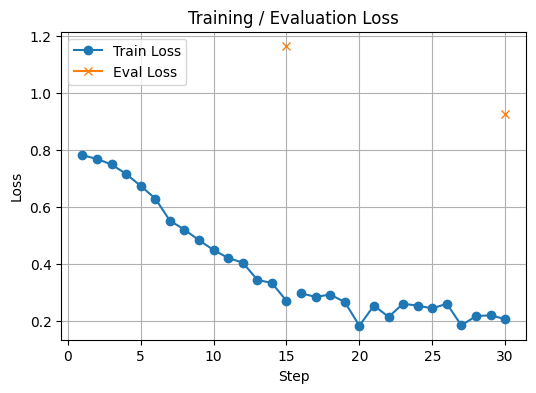

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# แปลง log_history เป็น DataFrame เพื่อจัดการง่าย
df = pd.DataFrame(trainer.state.log_history)

# ===== กราฟ Loss =====
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"], label="Train Loss", marker="o")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Eval Loss", marker="x")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training / Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ===== กราฟ Accuracy =====
if "eval_accuracy" in df.columns or "accuracy" in df.columns:
    plt.figure(figsize=(6,4))
    acc_col = "eval_accuracy" if "eval_accuracy" in df.columns else "accuracy"
    plt.plot(df["step"], df[acc_col], label="Eval Accuracy", color="green", marker="x")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

In [24]:
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # เช่น 20251004_1658
save_dir = f"lora_model_val_idx{idx_selected}_{timestamp}"

os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Model saved to: {save_dir}")

✅ Model saved to: lora_model_val_idx0_20251005_193653


#### 🥬 Round 2 (val idx 1)

In [12]:
# === Hyperparameter Set 1: "Conservative LR + Cosine schedule + more steps" ===
# แตกต่างจากเดิม:
# - learning_rate: 2e-4 -> 1e-4 (ลดความรุนแรงของการอัปเดต)
# - lr_scheduler_type: linear -> cosine (ลด LR แบบโค้งนิ่มลง)
# - warmup_steps: 5 -> 6 (อุ่นเครื่องนานขึ้นเล็กน้อย)
# - max_steps: 30 -> 60 (ฝึกนานขึ้น)
# - optim: adamw_8bit -> adamw_torch (เปลี่ยนตัว optimizer)
# - weight_decay: 0.01 -> 0.05 (regularization มากขึ้น)
# - max_grad_norm: 1.0 -> 0.5 (clip gradient เข้มขึ้น)
# - output_dir เปลี่ยนเป็น "outputs_set1"
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
import torch

trainer_set1 = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    eval_dataset = converted_dataset_val,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        per_device_eval_batch_size  = 4,
        gradient_accumulation_steps = 4,
        warmup_steps = 6,                     # CHANGED
        max_steps = 60,                       # CHANGED
        seed = 3407,

        eval_strategy = "steps",
        eval_steps = 30,                      # CHANGED
        prediction_loss_only = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,
        eval_accumulation_steps = 2,

        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        tf32 = True,

        learning_rate = 1e-4,                 # CHANGED
        optim = "adamw_torch",                # CHANGED
        weight_decay = 0.05,                  # CHANGED
        lr_scheduler_type = "cosine",         # CHANGED
        max_grad_norm = 0.5,                  # CHANGED

        dataloader_num_workers = 0,
        dataloader_pin_memory = True,
        dataloader_drop_last = False,

        report_to = ["tensorboard"],
        logging_strategy = "steps",
        logging_steps = 1,
        save_strategy = "no",
        save_total_limit = 1,
        load_best_model_at_end = False,

        output_dir = "outputs_set1",          # CHANGED

        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 1,
        max_seq_length = 1024,

        gradient_checkpointing = True,
    ),
    compute_metrics = compute_metrics
)

trainer_set1.predict_with_generate = True
trainer_set1.gen_kwargs = {
    "max_new_tokens": 128,
    "do_sample": False,
    "return_dict_in_generate": False,
    "output_scores": False,
}


Unsloth: Model does not have a default image size - using 512


In [13]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4050 Laptop GPU. Max memory = 5.997 GB.
2.465 GB of memory reserved.


In [16]:
from unsloth import unsloth_train

trainer_stats = unsloth_train(trainer_set1)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,310 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,084,928 of 3,795,707,904 (1.08% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
30,0.282000,1.162117
60,0.252100,0.932469


Unsloth: Not an error, but Qwen2_5_VLForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1025.0976 seconds used for training.
17.08 minutes used for training.
Peak reserved memory = 6.764 GB.
Peak reserved memory for training = 4.299 GB.
Peak reserved memory % of max memory = 112.79 %.
Peak reserved memory for training % of max memory = 71.686 %.


In [19]:
# ดูค่ารวม
import pandas as pd

# แปลง log เป็น DataFrame
df = pd.DataFrame(trainer_set1.state.log_history)
df_eval = df[df["eval_loss"].notnull()]                     # เอาเฉพาะบรรทัดที่มี eval_loss
final_eval = df_eval.iloc[-1]                               # ดึงบรรทัดสุดท้าย
eval_loss_final = final_eval["eval_loss"]

# ดูคอลัมน์ที่มี
print("Training loss for this fold   =", trainer_stats.training_loss)
print(f"Final Eval Loss for this fold = {eval_loss_final:.4f}")
print("All metrics:", trainer_stats.metrics)

display(df)

Training loss for this fold   = 0.4216022936006387
Final Eval Loss for this fold = 0.9325
All metrics: {'train_runtime': 1025.0976, 'train_samples_per_second': 0.468, 'train_steps_per_second': 0.059, 'total_flos': 4346869795356672.0, 'train_loss': 0.4216022936006387, 'epoch': 0.11136890951276102}


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.9793,2.768430,0.000000e+00,0.001856,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.9330,1.693358,1.666667e-05,0.003712,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.9404,1.802520,3.333333e-05,0.005568,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.9301,1.665295,5.000000e-05,0.007425,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.8811,1.510039,6.666667e-05,0.009281,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.2353,0.440168,7.596123e-07,0.107657,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,0.2149,0.447256,3.380821e-07,0.109513,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,0.2521,0.526875,8.459209e-08,0.111369,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,0.111369,60,0.932469,342.5282,2.517,0.631,NaN,NaN,NaN,NaN,NaN


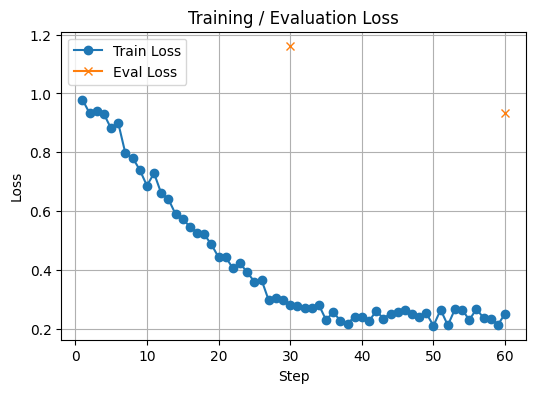

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# แปลง log_history เป็น DataFrame เพื่อจัดการง่าย
df = pd.DataFrame(trainer_set1.state.log_history)

# ===== กราฟ Loss =====
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"], label="Train Loss", marker="o")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Eval Loss", marker="x")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training / Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ===== กราฟ Accuracy =====
if "eval_accuracy" in df.columns or "accuracy" in df.columns:
    plt.figure(figsize=(6,4))
    acc_col = "eval_accuracy" if "eval_accuracy" in df.columns else "accuracy"
    plt.plot(df["step"], df[acc_col], label="Eval Accuracy", color="green", marker="x")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # เช่น 20251004_1658
save_dir = f"lora_model_val_idx{idx_selected}_{timestamp}"

os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Model saved to: {save_dir}")

✅ Model saved to: lora_model_val_idx1_20251005_200456


#### 🥬 Round 3 (val idx 2)

In [ ]:
# === Hyperparameter Set 2: "Larger batch per device + Cosine-with-restarts + higher LR" ===
# แตกต่างจากเดิม:
# - per_device_train_batch_size: 2 -> 4 (เพิ่ม batch ต่ออุปกรณ์)
# - per_device_eval_batch_size: 4 -> 8 (เพิ่ม batch ประเมิน)
# - gradient_accumulation_steps: 4 -> 2 (ลดเพื่อให้ effective batch ใกล้เคียงเดิม)
# - learning_rate: 2e-4 -> 3e-4 (ลอง LR ที่สูงขึ้น)
# - lr_scheduler_type: linear -> cosine_with_restarts (มีวัฏจักรย่อย ๆ)
# - eval_steps: 15 -> 10 (ประเมินถี่ขึ้น)
# - eval_accumulation_steps: 2 -> 1 (ลด memory ช่วง eval)
# - max_seq_length: 1024 -> 1536 (รองรับ sequence ยาวขึ้น)
# - output_dir เปลี่ยนเป็น "outputs_set2"
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
import torch

trainer_set2 = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    eval_dataset = converted_dataset_val,
    args = SFTConfig(
        per_device_train_batch_size = 4,       # CHANGED
        per_device_eval_batch_size  = 8,       # CHANGED
        gradient_accumulation_steps = 2,       # CHANGED
        warmup_steps = 5,
        max_steps = 30,
        seed = 3407,

        eval_strategy = "steps",
        eval_steps = 10,                       # CHANGED
        prediction_loss_only = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,
        eval_accumulation_steps = 1,           # CHANGED

        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        tf32 = True,

        learning_rate = 3e-4,                  # CHANGED
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine_with_restarts",  # CHANGED
        max_grad_norm = 1.0,

        dataloader_num_workers = 0,
        dataloader_pin_memory = True,
        dataloader_drop_last = False,

        report_to = ["tensorboard"],
        logging_strategy = "steps",
        logging_steps = 1,
        save_strategy = "no",
        save_total_limit = 1,
        load_best_model_at_end = False,

        output_dir = "outputs_set2",           # CHANGED

        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 1,
        max_seq_length = 1536,                 # CHANGED

        gradient_checkpointing = True,
    ),
    compute_metrics = compute_metrics
)

trainer_set2.predict_with_generate = True
trainer_set2.gen_kwargs = {
    "max_new_tokens": 128,
    "do_sample": False,
    "return_dict_in_generate": False,
    "output_scores": False,
}


Unsloth: Model does not have a default image size - using 512


In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4050 Laptop GPU. Max memory = 5.997 GB.
2.465 GB of memory reserved.


In [ ]:
from unsloth import unsloth_train

trainer_stats = unsloth_train(trainer_set2)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,310 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 2 x 1) = 8
 "-____-"     Trainable parameters = 41,084,928 of 3,795,707,904 (1.08% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
10,0.930900,1.692101
20,0.449400,0.978422
30,0.397900,0.919924


Unsloth: Not an error, but Qwen2_5_VLForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1293.5883 seconds used for training.
21.56 minutes used for training.
Peak reserved memory = 6.229 GB.
Peak reserved memory for training = 3.764 GB.
Peak reserved memory % of max memory = 103.869 %.
Peak reserved memory for training % of max memory = 62.765 %.


In [ ]:
# ดูค่ารวม
import pandas as pd

# แปลง log เป็น DataFrame
df = pd.DataFrame(trainer_set2.state.log_history)
df_eval = df[df["eval_loss"].notnull()]                     # เอาเฉพาะบรรทัดที่มี eval_loss
final_eval = df_eval.iloc[-1]                               # ดึงบรรทัดสุดท้าย
eval_loss_final = final_eval["eval_loss"]

# ดูคอลัมน์ที่มี
print("Training loss for this fold   =", trainer_stats.training_loss)
print(f"Final Eval Loss for this fold = {eval_loss_final:.4f}")
print("All metrics:", trainer_stats.metrics)

display(df)

Training loss for this fold   = 0.8425906846920649
Final Eval Loss for this fold = 0.9199
All metrics: {'train_runtime': 1293.5883, 'train_samples_per_second': 0.186, 'train_steps_per_second': 0.023, 'total_flos': 2221270703652864.0, 'train_loss': 0.8425906846920649, 'epoch': 0.055658627087198514}


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.9508,2.189928,0.000000,0.001855,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.8756,1.640249,0.000060,0.003711,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.8407,1.623699,0.000120,0.005566,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.7417,1.646072,0.000180,0.007421,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.5755,1.212267,0.000240,0.009276,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.4218,1.112914,0.000300,0.011132,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1.2413,1.046245,0.000299,0.012987,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.1501,1.038751,0.000295,0.014842,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0508,1.097420,0.000289,0.016698,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.9309,1.304464,0.000281,0.018553,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


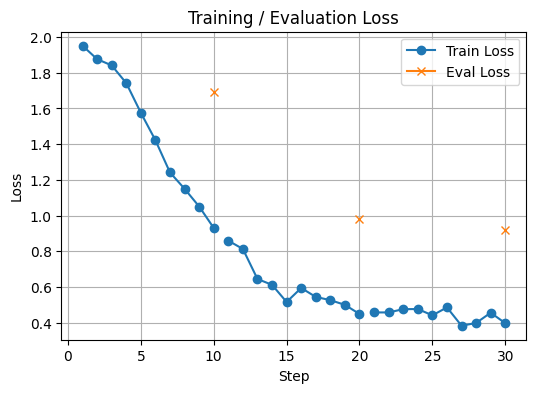

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# แปลง log_history เป็น DataFrame เพื่อจัดการง่าย
df = pd.DataFrame(trainer_set2.state.log_history)

# ===== กราฟ Loss =====
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"], label="Train Loss", marker="o")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Eval Loss", marker="x")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training / Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ===== กราฟ Accuracy =====
if "eval_accuracy" in df.columns or "accuracy" in df.columns:
    plt.figure(figsize=(6,4))
    acc_col = "eval_accuracy" if "eval_accuracy" in df.columns else "accuracy"
    plt.plot(df["step"], df[acc_col], label="Eval Accuracy", color="green", marker="x")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # เช่น 20251004_1658
save_dir = f"lora_model_val_idx{idx_selected}_{timestamp}"

os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Model saved to: {save_dir}")

✅ Model saved to: lora_model_val_idx2_20251005_203527


#### 🥬 Round 4 (val idx 3)

In [9]:
# === Hyperparameter Set 3: "Long-context focus + polynomial decay + no weight decay" ===
# แตกต่างจากเดิม:
# - per_device_train_batch_size: 2 -> 1 (เผื่อ VRAM สำหรับ seq ยาว)
# - per_device_eval_batch_size: 4 -> 2 (ลด eval batch ตาม VRAM)
# - gradient_accumulation_steps: 4 -> 8 (รักษา effective batch รวม)
# - max_seq_length: 1024 -> 2048 (รองรับ context ยาว)
# - learning_rate: 2e-4 -> 1.5e-4 (ลดเล็กน้อยเพื่อความเสถียรกับ context ยาว)
# - lr_scheduler_type: linear -> polynomial (โค้งลดกำลังสอง/กำลัง n)
# - weight_decay: 0.01 -> 0.0 (ปิด WD ทดสอบความต่าง)
# - warmup_steps: 5 -> 8 (อุ่นเครื่องเพิ่ม)
# - max_steps: 30 -> 40 (ฝึกนานขึ้นเล็กน้อย)
# - output_dir เปลี่ยนเป็น "outputs_set3"
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
import torch

trainer_set3 = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    eval_dataset = converted_dataset_val,
    args = SFTConfig(
        per_device_train_batch_size = 1,       # CHANGED
        per_device_eval_batch_size  = 2,       # CHANGED
        gradient_accumulation_steps = 8,       # CHANGED
        warmup_steps = 8,                       # CHANGED
        max_steps = 40,                         # CHANGED
        seed = 3407,

        eval_strategy = "steps",
        eval_steps = 15,
        prediction_loss_only = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,
        eval_accumulation_steps = 2,

        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        tf32 = True,

        learning_rate = 1.5e-4,                # CHANGED
        optim = "adamw_8bit",
        weight_decay = 0.0,                     # CHANGED
        lr_scheduler_type = "polynomial",       # CHANGED
        max_grad_norm = 1.0,

        dataloader_num_workers = 0,
        dataloader_pin_memory = True,
        dataloader_drop_last = False,

        report_to = ["tensorboard"],
        logging_strategy = "steps",
        logging_steps = 1,
        save_strategy = "no",
        save_total_limit = 1,
        load_best_model_at_end = False,

        output_dir = "outputs_set3",            # CHANGED

        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 1,
        max_seq_length = 2048,                  # CHANGED

        gradient_checkpointing = True,
    ),
    compute_metrics = compute_metrics
)

trainer_set3.predict_with_generate = True
trainer_set3.gen_kwargs = {
    "max_new_tokens": 128,
    "do_sample": False,
    "return_dict_in_generate": False,
    "output_scores": False,
}

Unsloth: Model does not have a default image size - using 512


In [10]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4050 Laptop GPU. Max memory = 5.997 GB.
2.465 GB of memory reserved.


In [11]:
from unsloth import unsloth_train

trainer_stats = unsloth_train(trainer_set3)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,310 | Num Epochs = 1 | Total steps = 40
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 41,084,928 of 3,795,707,904 (1.08% trained)


Step,Training Loss,Validation Loss
15,0.248900,1.954199
30,0.134000,1.050711


Unsloth: Not an error, but Qwen2_5_VLForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [12]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

916.6479 seconds used for training.
15.28 minutes used for training.
Peak reserved memory = 4.965 GB.
Peak reserved memory for training = 2.5 GB.
Peak reserved memory % of max memory = 82.791 %.
Peak reserved memory for training % of max memory = 41.688 %.


In [13]:
# ดูค่ารวม
import pandas as pd

# แปลง log เป็น DataFrame
df = pd.DataFrame(trainer_set3.state.log_history)
df_eval = df[df["eval_loss"].notnull()]                     # เอาเฉพาะบรรทัดที่มี eval_loss
final_eval = df_eval.iloc[-1]                               # ดึงบรรทัดสุดท้าย
eval_loss_final = final_eval["eval_loss"]

# ดูคอลัมน์ที่มี
print("Training loss for this fold   =", trainer_stats.training_loss)
print(f"Final Eval Loss for this fold = {eval_loss_final:.4f}")
print("All metrics:", trainer_stats.metrics)

display(df)

Training loss for this fold   = 0.23881329149007796
Final Eval Loss for this fold = 1.0507
All metrics: {'train_runtime': 916.6479, 'train_samples_per_second': 0.349, 'train_steps_per_second': 0.044, 'total_flos': 2755722936225792.0, 'train_loss': 0.23881329149007796, 'epoch': 0.07424593967517401}


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.4939,2.119401,0.000000,0.001856,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.4832,1.784608,0.000019,0.003712,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.4537,1.632744,0.000037,0.005568,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.4624,1.640307,0.000056,0.007425,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.4355,1.394392,0.000075,0.009281,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.4283,1.372211,0.000094,0.011137,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.4018,1.191673,0.000112,0.012993,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.3773,1.116006,0.000131,0.014849,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.3590,1.100156,0.000150,0.016705,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.3477,1.165369,0.000145,0.018561,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


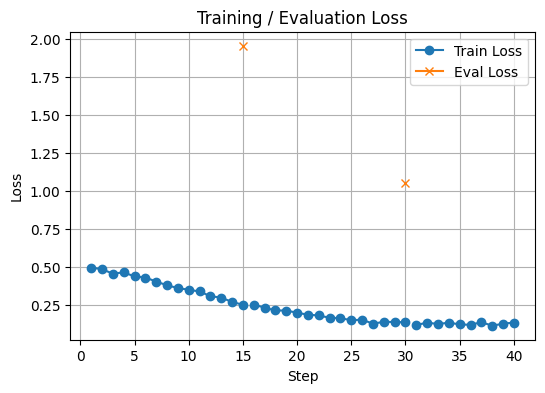

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# แปลง log_history เป็น DataFrame เพื่อจัดการง่าย
df = pd.DataFrame(trainer_set3.state.log_history)

# ===== กราฟ Loss =====
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"], label="Train Loss", marker="o")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Eval Loss", marker="x")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training / Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ===== กราฟ Accuracy =====
if "eval_accuracy" in df.columns or "accuracy" in df.columns:
    plt.figure(figsize=(6,4))
    acc_col = "eval_accuracy" if "eval_accuracy" in df.columns else "accuracy"
    plt.plot(df["step"], df[acc_col], label="Eval Accuracy", color="green", marker="x")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # เช่น 20251004_1658
save_dir = f"lora_model_val_idx{idx_selected}_{timestamp}"

os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Model saved to: {save_dir}")

✅ Model saved to: lora_model_val_idx3_20251005_205609


#### 🥬 Round 5 (val idx 4)

In [10]:
# === Hyperparameter Set 4: "Constant-with-warmup + save best on eval_loss" ===
# แตกต่างจากเดิม:
# - lr_scheduler_type: linear -> constant_with_warmup (LR คงที่หลัง warmup)
# - weight_decay: 0.01 -> 0.02 (เพิ่ม regularization เล็กน้อย)
# - max_grad_norm: 1.0 -> 0.8 (clip gradient เข้มขึ้นเล็กน้อย)
# - logging_steps: 1 -> 5 (ลดความถี่ logging)
# - save_strategy: "no" -> "steps" และเพิ่ม save_steps=40 (บันทึกเป็นช่วง ๆ)
# - load_best_model_at_end: False -> True (โหลดโมเดลที่ eval ดีสุดตอนจบ)
# - eval_strategy: "steps" คงเดิม แต่จะร่วมกับ save เพื่อเลือก best
# - output_dir เปลี่ยนเป็น "outputs_set4"
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
import torch

trainer_set4 = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    eval_dataset = converted_dataset_val,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        per_device_eval_batch_size  = 4,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 80,                         # CHANGED (ฝึกนานขึ้น)
        seed = 3407,

        eval_strategy = "steps",
        eval_steps = 20,                        # CHANGED (ประเมินห่างขึ้น)
        prediction_loss_only = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,
        eval_accumulation_steps = 2,

        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        tf32 = True,

        learning_rate = 2e-4,
        optim = "adamw_8bit",
        weight_decay = 0.02,                    # CHANGED
        lr_scheduler_type = "constant_with_warmup",  # CHANGED
        max_grad_norm = 0.8,                    # CHANGED

        dataloader_num_workers = 0,
        dataloader_pin_memory = True,
        dataloader_drop_last = False,

        report_to = ["tensorboard"],
        logging_strategy = "steps",
        logging_steps = 5,                      # CHANGED
        save_strategy = "steps",                # CHANGED
        save_steps = 40,                        # CHANGED
        save_total_limit = 1,
        load_best_model_at_end = True,          # CHANGED

        output_dir = "outputs_set4",            # CHANGED

        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 1,
        max_seq_length = 1024,

        gradient_checkpointing = True,
    ),
    compute_metrics = compute_metrics
)

trainer_set4.predict_with_generate = True
trainer_set4.gen_kwargs = {
    "max_new_tokens": 128,
    "do_sample": False,
    "return_dict_in_generate": False,
    "output_scores": False,
}


Unsloth: Model does not have a default image size - using 512


In [11]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4050 Laptop GPU. Max memory = 5.997 GB.
2.465 GB of memory reserved.


In [12]:
from unsloth import unsloth_train

trainer_stats = unsloth_train(trainer_set4)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,310 | Num Epochs = 1 | Total steps = 80
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,084,928 of 3,795,707,904 (1.08% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
20,0.286300,0.988202
40,0.170100,0.672817
60,0.131500,0.528003
80,0.124500,0.454099


Unsloth: Not an error, but Qwen2_5_VLForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [13]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1625.3629 seconds used for training.
27.09 minutes used for training.
Peak reserved memory = 6.029 GB.
Peak reserved memory for training = 3.564 GB.
Peak reserved memory % of max memory = 100.534 %.
Peak reserved memory for training % of max memory = 59.43 %.


In [14]:
# ดูค่ารวม
import pandas as pd

# แปลง log เป็น DataFrame
df = pd.DataFrame(trainer_set4.state.log_history)
df_eval = df[df["eval_loss"].notnull()]                     # เอาเฉพาะบรรทัดที่มี eval_loss
final_eval = df_eval.iloc[-1]                               # ดึงบรรทัดสุดท้าย
eval_loss_final = final_eval["eval_loss"]

# ดูคอลัมน์ที่มี
print("Training loss for this fold   =", trainer_stats.training_loss)
print(f"Final Eval Loss for this fold = {eval_loss_final:.4f}")
print("All metrics:", trainer_stats.metrics)

display(df)

Training loss for this fold   = 0.26264787167310716
Final Eval Loss for this fold = 0.4541
All metrics: {'train_runtime': 1625.3629, 'train_samples_per_second': 0.394, 'train_steps_per_second': 0.049, 'total_flos': 5772828410167296.0, 'train_loss': 0.26264787167310716, 'epoch': 0.14849187935034802}


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.9197,1.193786,0.00016,0.009281,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.6565,1.140536,0.00020,0.018561,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.4486,1.099614,0.00020,0.027842,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.2863,0.562006,0.00020,0.037123,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,0.037123,20,0.988202,274.4897,3.140,0.787,NaN,NaN,NaN,NaN,NaN
5,0.2332,0.500872,0.00020,0.046404,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.2088,0.580975,0.00020,0.055684,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.1928,0.443820,0.00020,0.064965,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.1701,0.612711,0.00020,0.074246,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,0.074246,40,0.672817,277.2335,3.109,0.779,NaN,NaN,NaN,NaN,NaN


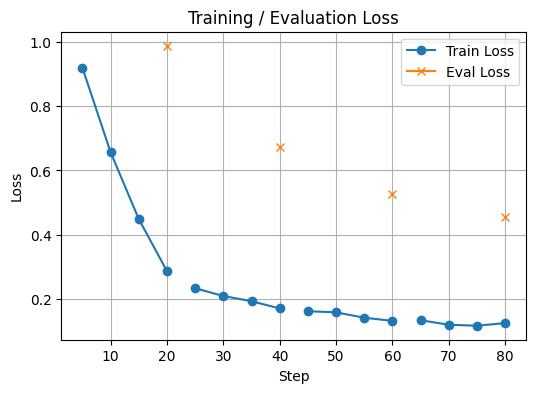

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# แปลง log_history เป็น DataFrame เพื่อจัดการง่าย
df = pd.DataFrame(trainer_set4.state.log_history)

# ===== กราฟ Loss =====
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"], label="Train Loss", marker="o")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Eval Loss", marker="x")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training / Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ===== กราฟ Accuracy =====
if "eval_accuracy" in df.columns or "accuracy" in df.columns:
    plt.figure(figsize=(6,4))
    acc_col = "eval_accuracy" if "eval_accuracy" in df.columns else "accuracy"
    plt.plot(df["step"], df[acc_col], label="Eval Accuracy", color="green", marker="x")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # เช่น 20251004_1658
save_dir = f"lora_model_val_idx{idx_selected}_{timestamp}"

os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Model saved to: {save_dir}")

✅ Model saved to: lora_model_val_idx4_20251005_212819


#### 🥬 Round 6 (val idx 5)

In [ ]:
# === Hyperparameter Set 5 (fixed): "BF16 steady + smaller LR + more warmup" ===
# เปลี่ยนจากเวอร์ชันเดิมของ Set5:
# - precision: ตั้งให้สอดคล้องกับโมเดลที่โหลดมาแล้ว -> fp16=False, bf16=True, tf32=True  (FIX)
# - per_device_train_batch_size: 2 -> 3
# - per_device_eval_batch_size: 4 -> 6
# - learning_rate: 2e-4 -> 5e-5
# - warmup_steps: 5 -> 10
# - lr_scheduler_type: linear -> constant_with_warmup
# - eval_steps: 15 -> 20
# - output_dir: "outputs_set5"
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
import torch

trainer_set5 = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    eval_dataset = converted_dataset_val,
    args = SFTConfig(
        # ===== Training schedule =====
        per_device_train_batch_size = 3,        # CHANGED
        per_device_eval_batch_size  = 6,        # CHANGED
        gradient_accumulation_steps = 4,
        warmup_steps = 10,                      # CHANGED
        max_steps = 30,
        seed = 3407,

        # ===== Eval =====
        eval_strategy = "steps",
        eval_steps = 20,                        # CHANGED
        prediction_loss_only = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,
        eval_accumulation_steps = 2,

        # ===== Precision / dtype (สอดคล้องกับโมเดลที่เป็น bf16) =====
        fp16 = False,                           # FIXED
        bf16 = True,                            # FIXED
        tf32 = True,                            # FIXED

        # ===== Optimization =====
        learning_rate = 5e-5,                   # CHANGED
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "constant_with_warmup",  # CHANGED
        max_grad_norm = 1.0,

        # ===== Dataloader =====
        dataloader_num_workers = 0,
        dataloader_pin_memory = True,
        dataloader_drop_last = False,

        # ===== Logging / Checkpoint IO =====
        report_to = ["tensorboard"],
        logging_strategy = "steps",
        logging_steps = 1,
        save_strategy = "no",
        save_total_limit = 1,
        load_best_model_at_end = False,

        # ===== Output =====
        output_dir = "outputs_set5",            # CHANGED

        # ===== Vision finetuning (required) =====
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 1,
        max_seq_length = 1024,

        # ===== Memory saver =====
        gradient_checkpointing = True,
    ),
    compute_metrics = compute_metrics
)

trainer_set5.predict_with_generate = True
trainer_set5.gen_kwargs = {
    "max_new_tokens": 128,
    "do_sample": False,
    "return_dict_in_generate": False,
    "output_scores": False,
}

Unsloth: Model does not have a default image size - using 512


In [12]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4050 Laptop GPU. Max memory = 5.997 GB.
2.465 GB of memory reserved.


In [13]:
from unsloth import unsloth_train

trainer_stats = unsloth_train(trainer_set5)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,310 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 3 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (3 x 4 x 1) = 12
 "-____-"     Trainable parameters = 41,084,928 of 3,795,707,904 (1.08% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
20,0.644000,2.537837


Unsloth: Not an error, but Qwen2_5_VLForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [14]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

628.2143 seconds used for training.
10.47 minutes used for training.
Peak reserved memory = 9.244 GB.
Peak reserved memory for training = 6.779 GB.
Peak reserved memory % of max memory = 154.144 %.
Peak reserved memory for training % of max memory = 113.04 %.


In [15]:
# ดูค่ารวม
import pandas as pd

# แปลง log เป็น DataFrame
df = pd.DataFrame(trainer_set5.state.log_history)
df_eval = df[df["eval_loss"].notnull()]                     # เอาเฉพาะบรรทัดที่มี eval_loss
final_eval = df_eval.iloc[-1]                               # ดึงบรรทัดสุดท้าย
eval_loss_final = final_eval["eval_loss"]

# ดูคอลัมน์ที่มี
print("Training loss for this fold   =", trainer_stats.training_loss)
print(f"Final Eval Loss for this fold = {eval_loss_final:.4f}")
print("All metrics:", trainer_stats.metrics)

display(df)

Training loss for this fold   = 0.7400482495625814
Final Eval Loss for this fold = 2.5378
All metrics: {'train_runtime': 628.2143, 'train_samples_per_second': 0.573, 'train_steps_per_second': 0.048, 'total_flos': 3299228011450368.0, 'train_loss': 0.7400482495625814, 'epoch': 0.08350730688935282}


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.9629,1.921401,0.000000,0.002784,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.9372,1.684279,0.000005,0.005567,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.9183,1.672936,0.000010,0.008351,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.9235,1.694051,0.000015,0.011134,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.8962,1.560194,0.000020,0.013918,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.9170,1.627645,0.000025,0.016701,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.9428,1.653763,0.000030,0.019485,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.9051,1.598700,0.000035,0.022269,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.8613,1.412274,0.000040,0.025052,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.8608,1.432127,0.000045,0.027836,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


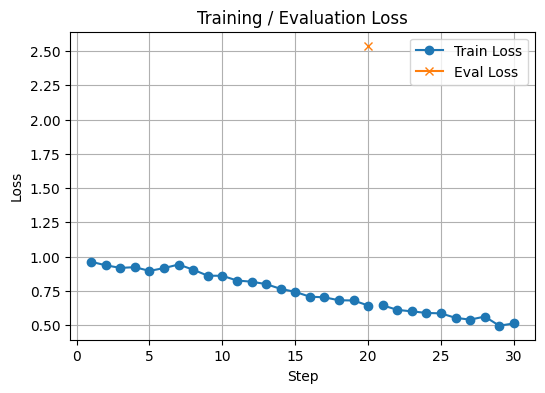

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# แปลง log_history เป็น DataFrame เพื่อจัดการง่าย
# df = pd.DataFrame(trainer_set4.state.log_history)

# ===== กราฟ Loss =====
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"], label="Train Loss", marker="o")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Eval Loss", marker="x")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training / Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ===== กราฟ Accuracy =====
if "eval_accuracy" in df.columns or "accuracy" in df.columns:
    plt.figure(figsize=(6,4))
    acc_col = "eval_accuracy" if "eval_accuracy" in df.columns else "accuracy"
    plt.plot(df["step"], df[acc_col], label="Eval Accuracy", color="green", marker="x")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # เช่น 20251004_1658
save_dir = f"lora_model_val_idx{idx_selected}_{timestamp}"

os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Model saved to: {save_dir}")

✅ Model saved to: lora_model_val_idx5_20251005_214520


### 6. หาค่า Eval Accuracy โดยการทำ Manual Eval

#### 🥬 Round 1 (val idx 0)

In [1]:
import re, torch, pandas as pd
from tqdm import tqdm
from unsloth import FastVisionModel
from transformers import TextStreamer

# ===== 0) โหลดโมเดล + LoRA (เหมือนเดิม) =====
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)
model.load_adapter("lora_model_val_idx0_20251005_193653")
FastVisionModel.for_inference(model)
model.eval()

c:\Users\namth\anaconda3\envs\lung_lora\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


W1005 23:25:35.496000 19828 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


🦥 Unsloth Zoo will now patch everything to make training faster!


c:\Users\namth\anaconda3\envs\lung_lora\lib\site-packages\unsloth_zoo\gradient_checkpointing.py:341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"{DEVICE_TYPE}:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.9.11: Fast Qwen2_5_Vl patching. Transformers: 4.56.2.
   \\   /|    NVIDIA GeForce RTX 4050 Laptop GPU. Num GPUs = 1. Max memory: 5.997 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.8.0+cu129. CUDA: 8.9. CUDA Toolkit: 12.9. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


Qwen2_5_VLForConditionalGeneration(
  (model): Qwen2_5_VLModel(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionAttention(
            (qkv): lora.Linear4bit(
              (base_layer): Linear4bit(in_features=1280, out_features=3840, bias=True)
              (lora_dropout): ModuleDict(
                (default): Identity()
              )
              (lora_A): ModuleDict(
                (default): Linear(in_features=1280, out_features=16, bias=False)
              )
              (lora_B): ModuleDict(
                (default): Linear(in_features=16, out_features=3840, bi

In [2]:
from datasets import load_from_disk

hf = load_from_disk("lung8_image_text")

splits = hf.train_test_split(test_size=0.15, seed=42, shuffle=True)

train_hf = splits["train"]
blind_test_hf = splits["test"]       # blind test

# แสดงขนาดของแต่ละชุด
print(f"Total dataset size : {len(hf):,}")
print(f"Train set size     : {len(train_hf):,} ({len(train_hf)/len(hf)*100:.2f}%)")
print(f"Test set size      : {len(blind_test_hf):,} ({len(blind_test_hf)/len(hf)*100:.2f}%)")

n = len(train_hf)
k = 6
fold_size = n // k

folds = []
for i in range(k):
    start = i * fold_size
    end = (i + 1) * fold_size if i < k - 1 else n
    fold = train_hf.select(range(start, end))
    folds.append(fold)

idx_selected = 0                        # ← แก้เลขในนี้ได้ตามต้องการ
val_selected = folds[idx_selected]            

print(f"Total train_hf : {n}")
print(f"Each fold size : {fold_size}")
print(val_selected)

Total dataset size : 6,085
Train set size     : 5,172 (85.00%)
Test set size      : 913 (15.00%)
Total train_hf : 5172
Each fold size : 862
Dataset({
    features: ['image', 'text', '__class__'],
    num_rows: 862
})


In [4]:
import re, torch, pandas as pd
from tqdm import tqdm

# ===== 1) ใช้แค่ 30 ตัวแรก =====
subset = val_selected.select(range(30))

CLASS_SET = {
    "Chest_Changes","Degenerative_Infectious","Higher_Density",
    "Inflammatory_Pneumonia","Lower_Density","Mediastinal_Changes",
    "Normal","Obstructive",
}

instruction = (
    "Describe the chest X-ray using precise clinical terms. "
    "Identify one main diagnostic category from: "
    "Chest_Changes, Degenerative_Infectious, Higher_Density, "
    "Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, "
    "Normal, or Obstructive."
)

def extract_class_strict(text: str):
    if not isinstance(text, str) or not text.strip():
        return None
    # 1) จับจาก "Class: <ชื่อคลาส>" ก่อน (multi-line, case-insensitive)
    m = re.search(r"(?im)^\s*Class\s*:\s*([A-Za-z_]+)", text)
    if m:
        cand = m.group(1)
        # ไม่สนพิมพ์เล็กใหญ่ แต่คืนชื่อมาตรฐาน
        for cls in CLASS_SET:
            if cand.lower() == cls.lower():
                return cls
        return None
    # 2) Fallback: ถ้าจำเป็นจริง ๆ ค่อยสแกนทั้งข้อความ (เลี่ยง prompt echo)
    for cls in sorted(CLASS_SET, key=str.lower):
        if re.search(rf"\b{re.escape(cls)}\b", text, flags=re.IGNORECASE):
            return cls
    return None

rows = []
correct = total = 0

for i, example in enumerate(subset):
    image = example["image"]

    # label จริงมาจาก __class__
    true_class = example["__class__"]

    # image_id (ถ้าไม่มีคอลัมน์ id ใช้ดัชนี i)
    image_id = example.get("id", i)

    # [changed] ส่ง instruction เดียวกันทุกภาพเข้า chat template
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to(model.device)

    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            use_cache=True,
            return_dict_in_generate=False,
            output_scores=False,
        )

    # ตัด prompt ออก: ใช้ความยาว input_ids เป็นตัวแบ่ง
    input_len = inputs["input_ids"].shape[1]
    gen_ids = out_ids[0][input_len:]                 # <-- เฉพาะที่โมเดลสร้างใหม่
    decoded_text = tokenizer.decode(gen_ids, skip_special_tokens=True)
    
    pred_class = extract_class_strict(decoded_text)
    print(f"id: {image_id}, true_class : {true_class}, pred_class : {pred_class}")

    # อัปเดต accuracy (นับเมื่อ true_class เป็นคลาสใน ALLOWED_CLASSES)
    if true_class in CLASS_SET:
        total += 1
        if pred_class == true_class:
            correct += 1

    rows.append({
        "image_id": image_id,
        "pred_class": pred_class,
        "true_class": true_class,
        "decoded_text": decoded_text,
    })

# ===== 2) สรุป accuracy =====
acc = correct / total if total > 0 else 0.0
print(f"\n✅ Manual eval_accuracy on 30 samples: {acc:.4f} ({correct}/{total})")

# ===== 3) เซฟ CSV =====
df = pd.DataFrame(rows, columns=["image_id", "pred_class", "true_class", "decoded_text"])
csv_path = f"vl_eval_predictions_idx{idx_selected}.csv"
df.to_csv(csv_path, index=False, encoding="utf-8-sig")
print(f"💾 Saved CSV -> {csv_path}")

id: 0, true_class : Normal, pred_class : Inflammatory_Pneumonia
id: 1, true_class : Mediastinal_Changes, pred_class : Inflammatory_Pneumonia
id: 2, true_class : Higher_Density, pred_class : Inflammatory_Pneumonia
id: 3, true_class : Higher_Density, pred_class : Inflammatory_Pneumonia
id: 4, true_class : Inflammatory_Pneumonia, pred_class : Inflammatory_Pneumonia
id: 5, true_class : Inflammatory_Pneumonia, pred_class : Inflammatory_Pneumonia
id: 6, true_class : Normal, pred_class : Normal
id: 7, true_class : Inflammatory_Pneumonia, pred_class : Inflammatory_Pneumonia
id: 8, true_class : Higher_Density, pred_class : Inflammatory_Pneumonia
id: 9, true_class : Obstructive, pred_class : Inflammatory_Pneumonia
id: 10, true_class : Normal, pred_class : Inflammatory_Pneumonia
id: 11, true_class : Degenerative_Infectious, pred_class : Inflammatory_Pneumonia
id: 12, true_class : Chest_Changes, pred_class : Inflammatory_Pneumonia
id: 13, true_class : Mediastinal_Changes, pred_class : Inflammatory

#### 🥬 Round 2 (val idx 1)

In [5]:
import re, torch, pandas as pd
from tqdm import tqdm
from unsloth import FastVisionModel
from transformers import TextStreamer

# ===== 0) โหลดโมเดล + LoRA (เหมือนเดิม) =====
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)
model.load_adapter("lora_model_val_idx1_20251005_200456")
FastVisionModel.for_inference(model)
model.eval()

==((====))==  Unsloth 2025.9.11: Fast Qwen2_5_Vl patching. Transformers: 4.56.2.
   \\   /|    NVIDIA GeForce RTX 4050 Laptop GPU. Num GPUs = 1. Max memory: 5.997 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.8.0+cu129. CUDA: 8.9. CUDA Toolkit: 12.9. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Qwen2_5_VLForConditionalGeneration(
  (model): Qwen2_5_VLModel(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionAttention(
            (qkv): lora.Linear4bit(
              (base_layer): Linear4bit(in_features=1280, out_features=3840, bias=True)
              (lora_dropout): ModuleDict(
                (default): Identity()
              )
              (lora_A): ModuleDict(
                (default): Linear(in_features=1280, out_features=16, bias=False)
              )
              (lora_B): ModuleDict(
                (default): Linear(in_features=16, out_features=3840, bi

In [6]:
from datasets import load_from_disk

hf = load_from_disk("lung8_image_text")

splits = hf.train_test_split(test_size=0.15, seed=42, shuffle=True)

train_hf = splits["train"]
blind_test_hf = splits["test"]       # blind test

# แสดงขนาดของแต่ละชุด
print(f"Total dataset size : {len(hf):,}")
print(f"Train set size     : {len(train_hf):,} ({len(train_hf)/len(hf)*100:.2f}%)")
print(f"Test set size      : {len(blind_test_hf):,} ({len(blind_test_hf)/len(hf)*100:.2f}%)")

n = len(train_hf)
k = 6
fold_size = n // k

folds = []
for i in range(k):
    start = i * fold_size
    end = (i + 1) * fold_size if i < k - 1 else n
    fold = train_hf.select(range(start, end))
    folds.append(fold)

idx_selected = 1                        # ← แก้เลขในนี้ได้ตามต้องการ
val_selected = folds[idx_selected]            

print(f"Total train_hf : {n}")
print(f"Each fold size : {fold_size}")
print(val_selected)

Total dataset size : 6,085
Train set size     : 5,172 (85.00%)
Test set size      : 913 (15.00%)
Total train_hf : 5172
Each fold size : 862
Dataset({
    features: ['image', 'text', '__class__'],
    num_rows: 862
})


In [8]:
import re, torch, pandas as pd
from tqdm import tqdm

# ===== 1) ใช้แค่ 30 ตัวแรก =====
subset = val_selected.select(range(30))

CLASS_SET = {
    "Chest_Changes","Degenerative_Infectious","Higher_Density",
    "Inflammatory_Pneumonia","Lower_Density","Mediastinal_Changes",
    "Normal","Obstructive",
}

instruction = (
    "Describe the chest X-ray using precise clinical terms. "
    "Identify one main diagnostic category from: "
    "Chest_Changes, Degenerative_Infectious, Higher_Density, "
    "Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, "
    "Normal, or Obstructive."
)

def extract_class_strict(text: str):
    if not isinstance(text, str) or not text.strip():
        return None
    # 1) จับจาก "Class: <ชื่อคลาส>" ก่อน (multi-line, case-insensitive)
    m = re.search(r"(?im)^\s*Class\s*:\s*([A-Za-z_]+)", text)
    if m:
        cand = m.group(1)
        # ไม่สนพิมพ์เล็กใหญ่ แต่คืนชื่อมาตรฐาน
        for cls in CLASS_SET:
            if cand.lower() == cls.lower():
                return cls
        return None
    # 2) Fallback: ถ้าจำเป็นจริง ๆ ค่อยสแกนทั้งข้อความ (เลี่ยง prompt echo)
    for cls in sorted(CLASS_SET, key=str.lower):
        if re.search(rf"\b{re.escape(cls)}\b", text, flags=re.IGNORECASE):
            return cls
    return None

rows = []
correct = total = 0

for i, example in enumerate(subset):
    image = example["image"]

    # label จริงมาจาก __class__
    true_class = example["__class__"]

    # image_id (ถ้าไม่มีคอลัมน์ id ใช้ดัชนี i)
    image_id = example.get("id", i)

    # [changed] ส่ง instruction เดียวกันทุกภาพเข้า chat template
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to(model.device)

    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            use_cache=True,
            return_dict_in_generate=False,
            output_scores=False,
        )

    # ตัด prompt ออก: ใช้ความยาว input_ids เป็นตัวแบ่ง
    input_len = inputs["input_ids"].shape[1]
    gen_ids = out_ids[0][input_len:]                 # <-- เฉพาะที่โมเดลสร้างใหม่
    decoded_text = tokenizer.decode(gen_ids, skip_special_tokens=True)
    
    pred_class = extract_class_strict(decoded_text)
    print(f"id: {image_id}, true_class : {true_class}, pred_class : {pred_class}")

    # อัปเดต accuracy (นับเมื่อ true_class เป็นคลาสใน ALLOWED_CLASSES)
    if true_class in CLASS_SET:
        total += 1
        if pred_class == true_class:
            correct += 1

    rows.append({
        "image_id": image_id,
        "pred_class": pred_class,
        "true_class": true_class,
        "decoded_text": decoded_text,
    })

# ===== 2) สรุป accuracy =====
acc = correct / total if total > 0 else 0.0
print(f"\n✅ Manual eval_accuracy on 30 samples: {acc:.4f} ({correct}/{total})")

# ===== 3) เซฟ CSV =====
df = pd.DataFrame(rows, columns=["image_id", "pred_class", "true_class", "decoded_text"])
csv_path = f"vl_eval_predictions_idx{idx_selected}.csv"
df.to_csv(csv_path, index=False, encoding="utf-8-sig")
print(f"💾 Saved CSV -> {csv_path}")

id: 0, true_class : Normal, pred_class : Normal
id: 1, true_class : Lower_Density, pred_class : Inflammatory_Pneumonia
id: 2, true_class : Inflammatory_Pneumonia, pred_class : Normal
id: 3, true_class : Normal, pred_class : Inflammatory_Pneumonia
id: 4, true_class : Normal, pred_class : Inflammatory_Pneumonia
id: 5, true_class : Lower_Density, pred_class : Inflammatory_Pneumonia
id: 6, true_class : Obstructive, pred_class : Inflammatory_Pneumonia
id: 7, true_class : Lower_Density, pred_class : Mediastinal_Changes
id: 8, true_class : Normal, pred_class : Inflammatory_Pneumonia
id: 9, true_class : Mediastinal_Changes, pred_class : Mediastinal_Changes
id: 10, true_class : Chest_Changes, pred_class : Inflammatory_Pneumonia
id: 11, true_class : Higher_Density, pred_class : Inflammatory_Pneumonia
id: 12, true_class : Inflammatory_Pneumonia, pred_class : Inflammatory_Pneumonia
id: 13, true_class : Mediastinal_Changes, pred_class : Mediastinal_Changes
id: 14, true_class : Inflammatory_Pneumoni

#### 🥬 Round 3 (val idx 2)

In [1]:
import re, torch, pandas as pd
from tqdm import tqdm
from unsloth import FastVisionModel
from transformers import TextStreamer

# ===== 0) โหลดโมเดล + LoRA (เหมือนเดิม) =====
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)
model.load_adapter("lora_model_val_idx2_20251005_203527")
FastVisionModel.for_inference(model)
model.eval()

c:\Users\namth\anaconda3\envs\lung_lora\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


W1005 23:51:33.595000 21900 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


🦥 Unsloth Zoo will now patch everything to make training faster!


c:\Users\namth\anaconda3\envs\lung_lora\lib\site-packages\unsloth_zoo\gradient_checkpointing.py:341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"{DEVICE_TYPE}:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.9.11: Fast Qwen2_5_Vl patching. Transformers: 4.56.2.
   \\   /|    NVIDIA GeForce RTX 4050 Laptop GPU. Num GPUs = 1. Max memory: 5.997 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.8.0+cu129. CUDA: 8.9. CUDA Toolkit: 12.9. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


Qwen2_5_VLForConditionalGeneration(
  (model): Qwen2_5_VLModel(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionAttention(
            (qkv): lora.Linear4bit(
              (base_layer): Linear4bit(in_features=1280, out_features=3840, bias=True)
              (lora_dropout): ModuleDict(
                (default): Identity()
              )
              (lora_A): ModuleDict(
                (default): Linear(in_features=1280, out_features=16, bias=False)
              )
              (lora_B): ModuleDict(
                (default): Linear(in_features=16, out_features=3840, bi

In [2]:
from datasets import load_from_disk

hf = load_from_disk("lung8_image_text")

splits = hf.train_test_split(test_size=0.15, seed=42, shuffle=True)

train_hf = splits["train"]
blind_test_hf = splits["test"]       # blind test

# แสดงขนาดของแต่ละชุด
print(f"Total dataset size : {len(hf):,}")
print(f"Train set size     : {len(train_hf):,} ({len(train_hf)/len(hf)*100:.2f}%)")
print(f"Test set size      : {len(blind_test_hf):,} ({len(blind_test_hf)/len(hf)*100:.2f}%)")

n = len(train_hf)
k = 6
fold_size = n // k

folds = []
for i in range(k):
    start = i * fold_size
    end = (i + 1) * fold_size if i < k - 1 else n
    fold = train_hf.select(range(start, end))
    folds.append(fold)

idx_selected = 2                        # ← แก้เลขในนี้ได้ตามต้องการ
val_selected = folds[idx_selected]            

print(f"Total train_hf : {n}")
print(f"Each fold size : {fold_size}")
print(val_selected[0:5]["__class__"])

Total dataset size : 6,085
Train set size     : 5,172 (85.00%)
Test set size      : 913 (15.00%)
Total train_hf : 5172
Each fold size : 862
['Higher_Density', 'Inflammatory_Pneumonia', 'Obstructive', 'Obstructive', 'Inflammatory_Pneumonia']


In [3]:
import re, torch, pandas as pd
from tqdm import tqdm

# ===== 1) ใช้แค่ 30 ตัวแรก =====
subset = val_selected.select(range(30))

CLASS_SET = {
    "Chest_Changes","Degenerative_Infectious","Higher_Density",
    "Inflammatory_Pneumonia","Lower_Density","Mediastinal_Changes",
    "Normal","Obstructive",
}

instruction = (
    "Describe the chest X-ray using precise clinical terms. "
    "Identify one main diagnostic category from: "
    "Chest_Changes, Degenerative_Infectious, Higher_Density, "
    "Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, "
    "Normal, or Obstructive."
)

def extract_class_strict(text: str):
    if not isinstance(text, str) or not text.strip():
        return None
    # 1) จับจาก "Class: <ชื่อคลาส>" ก่อน (multi-line, case-insensitive)
    m = re.search(r"(?im)^\s*Class\s*:\s*([A-Za-z_]+)", text)
    if m:
        cand = m.group(1)
        # ไม่สนพิมพ์เล็กใหญ่ แต่คืนชื่อมาตรฐาน
        for cls in CLASS_SET:
            if cand.lower() == cls.lower():
                return cls
        return None
    # 2) Fallback: ถ้าจำเป็นจริง ๆ ค่อยสแกนทั้งข้อความ (เลี่ยง prompt echo)
    for cls in sorted(CLASS_SET, key=str.lower):
        if re.search(rf"\b{re.escape(cls)}\b", text, flags=re.IGNORECASE):
            return cls
    return None

rows = []
correct = total = 0

for i, example in enumerate(subset):
    image = example["image"]

    # label จริงมาจาก __class__
    true_class = example["__class__"]

    # image_id (ถ้าไม่มีคอลัมน์ id ใช้ดัชนี i)
    image_id = example.get("id", i)

    # [changed] ส่ง instruction เดียวกันทุกภาพเข้า chat template
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to(model.device)

    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            use_cache=True,
            return_dict_in_generate=False,
            output_scores=False,
        )

    # ตัด prompt ออก: ใช้ความยาว input_ids เป็นตัวแบ่ง
    input_len = inputs["input_ids"].shape[1]
    gen_ids = out_ids[0][input_len:]                 # <-- เฉพาะที่โมเดลสร้างใหม่
    decoded_text = tokenizer.decode(gen_ids, skip_special_tokens=True)
    
    pred_class = extract_class_strict(decoded_text)
    print(f"id: {image_id}, true_class : {true_class}, pred_class : {pred_class}")

    # อัปเดต accuracy (นับเมื่อ true_class เป็นคลาสใน CLASS_SET)
    if true_class in CLASS_SET:
        total += 1
        if pred_class == true_class:
            correct += 1

    rows.append({
        "image_id": image_id,
        "pred_class": pred_class,
        "true_class": true_class,
        "decoded_text": decoded_text,
    })

# ===== 2) สรุป accuracy =====
acc = correct / total if total > 0 else 0.0
print(f"\n✅ Manual eval_accuracy on 30 samples: {acc:.4f} ({correct}/{total})")

# ===== 3) เซฟ CSV =====
df = pd.DataFrame(rows, columns=["image_id", "pred_class", "true_class", "decoded_text"])
csv_path = f"vl_eval_predictions_idx{idx_selected}.csv"
df.to_csv(csv_path, index=False, encoding="utf-8-sig")
print(f"💾 Saved CSV -> {csv_path}")

id: 0, true_class : Higher_Density, pred_class : Inflammatory_Pneumonia
id: 1, true_class : Inflammatory_Pneumonia, pred_class : Inflammatory_Pneumonia
id: 2, true_class : Obstructive, pred_class : Inflammatory_Pneumonia
id: 3, true_class : Obstructive, pred_class : Inflammatory_Pneumonia
id: 4, true_class : Inflammatory_Pneumonia, pred_class : Inflammatory_Pneumonia
id: 5, true_class : Chest_Changes, pred_class : Inflammatory_Pneumonia
id: 6, true_class : Normal, pred_class : Inflammatory_Pneumonia
id: 7, true_class : Lower_Density, pred_class : Inflammatory_Pneumonia
id: 8, true_class : Inflammatory_Pneumonia, pred_class : Inflammatory_Pneumonia
id: 9, true_class : Obstructive, pred_class : Inflammatory_Pneumonia
id: 10, true_class : Lower_Density, pred_class : Inflammatory_Pneumonia
id: 11, true_class : Degenerative_Infectious, pred_class : Inflammatory_Pneumonia
id: 12, true_class : Inflammatory_Pneumonia, pred_class : Inflammatory_Pneumonia
id: 13, true_class : Inflammatory_Pneumo

#### 🥬 Round 4 (val idx 3)

In [4]:
import re, torch, pandas as pd
from tqdm import tqdm
from unsloth import FastVisionModel
from transformers import TextStreamer

# ===== 0) โหลดโมเดล + LoRA (เหมือนเดิม) =====
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)
model.load_adapter("lora_model_val_idx3_20251005_205609")
FastVisionModel.for_inference(model)
model.eval()

==((====))==  Unsloth 2025.9.11: Fast Qwen2_5_Vl patching. Transformers: 4.56.2.
   \\   /|    NVIDIA GeForce RTX 4050 Laptop GPU. Num GPUs = 1. Max memory: 5.997 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.8.0+cu129. CUDA: 8.9. CUDA Toolkit: 12.9. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Qwen2_5_VLForConditionalGeneration(
  (model): Qwen2_5_VLModel(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionAttention(
            (qkv): lora.Linear4bit(
              (base_layer): Linear4bit(in_features=1280, out_features=3840, bias=True)
              (lora_dropout): ModuleDict(
                (default): Identity()
              )
              (lora_A): ModuleDict(
                (default): Linear(in_features=1280, out_features=16, bias=False)
              )
              (lora_B): ModuleDict(
                (default): Linear(in_features=16, out_features=3840, bi

In [6]:
from datasets import load_from_disk

hf = load_from_disk("lung8_image_text")

splits = hf.train_test_split(test_size=0.15, seed=42, shuffle=True)

train_hf = splits["train"]
blind_test_hf = splits["test"]       # blind test

# แสดงขนาดของแต่ละชุด
print(f"Total dataset size : {len(hf):,}")
print(f"Train set size     : {len(train_hf):,} ({len(train_hf)/len(hf)*100:.2f}%)")
print(f"Test set size      : {len(blind_test_hf):,} ({len(blind_test_hf)/len(hf)*100:.2f}%)")

n = len(train_hf)
k = 6
fold_size = n // k

folds = []
for i in range(k):
    start = i * fold_size
    end = (i + 1) * fold_size if i < k - 1 else n
    fold = train_hf.select(range(start, end))
    folds.append(fold)

idx_selected = 3                        # ← แก้เลขในนี้ได้ตามต้องการ
val_selected = folds[idx_selected]            

print(f"Total train_hf : {n}")
print(f"Each fold size : {fold_size}")
print(val_selected[0:5]["__class__"])

Total dataset size : 6,085
Train set size     : 5,172 (85.00%)
Test set size      : 913 (15.00%)
Total train_hf : 5172
Each fold size : 862
['Normal', 'Higher_Density', 'Degenerative_Infectious', 'Inflammatory_Pneumonia', 'Inflammatory_Pneumonia']


In [7]:
import re, torch, pandas as pd
from tqdm import tqdm

# ===== 1) ใช้แค่ 30 ตัวแรก =====
subset = val_selected.select(range(30))

CLASS_SET = {
    "Chest_Changes","Degenerative_Infectious","Higher_Density",
    "Inflammatory_Pneumonia","Lower_Density","Mediastinal_Changes",
    "Normal","Obstructive",
}

instruction = (
    "Describe the chest X-ray using precise clinical terms. "
    "Identify one main diagnostic category from: "
    "Chest_Changes, Degenerative_Infectious, Higher_Density, "
    "Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, "
    "Normal, or Obstructive."
)

def extract_class_strict(text: str):
    if not isinstance(text, str) or not text.strip():
        return None
    # 1) จับจาก "Class: <ชื่อคลาส>" ก่อน (multi-line, case-insensitive)
    m = re.search(r"(?im)^\s*Class\s*:\s*([A-Za-z_]+)", text)
    if m:
        cand = m.group(1)
        # ไม่สนพิมพ์เล็กใหญ่ แต่คืนชื่อมาตรฐาน
        for cls in CLASS_SET:
            if cand.lower() == cls.lower():
                return cls
        return None
    # 2) Fallback: ถ้าจำเป็นจริง ๆ ค่อยสแกนทั้งข้อความ (เลี่ยง prompt echo)
    for cls in sorted(CLASS_SET, key=str.lower):
        if re.search(rf"\b{re.escape(cls)}\b", text, flags=re.IGNORECASE):
            return cls
    return None

rows = []
correct = total = 0

for i, example in enumerate(subset):
    image = example["image"]

    # label จริงมาจาก __class__
    true_class = example["__class__"]

    # image_id (ถ้าไม่มีคอลัมน์ id ใช้ดัชนี i)
    image_id = example.get("id", i)

    # [changed] ส่ง instruction เดียวกันทุกภาพเข้า chat template
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to(model.device)

    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            use_cache=True,
            return_dict_in_generate=False,
            output_scores=False,
        )

    # ตัด prompt ออก: ใช้ความยาว input_ids เป็นตัวแบ่ง
    input_len = inputs["input_ids"].shape[1]
    gen_ids = out_ids[0][input_len:]                 # <-- เฉพาะที่โมเดลสร้างใหม่
    decoded_text = tokenizer.decode(gen_ids, skip_special_tokens=True)
    
    pred_class = extract_class_strict(decoded_text)
    print(f"id: {image_id}, true_class : {true_class}, pred_class : {pred_class}")

    # อัปเดต accuracy (นับเมื่อ true_class เป็นคลาสใน CLASS_SET)
    if true_class in CLASS_SET:
        total += 1
        if pred_class == true_class:
            correct += 1

    rows.append({
        "image_id": image_id,
        "pred_class": pred_class,
        "true_class": true_class,
        "decoded_text": decoded_text,
    })

# ===== 2) สรุป accuracy =====
acc = correct / total if total > 0 else 0.0
print(f"\n✅ Manual eval_accuracy on 30 samples: {acc:.4f} ({correct}/{total})")

# ===== 3) เซฟ CSV =====
df = pd.DataFrame(rows, columns=["image_id", "pred_class", "true_class", "decoded_text"])
csv_path = f"vl_eval_predictions_idx{idx_selected}.csv"
df.to_csv(csv_path, index=False, encoding="utf-8-sig")
print(f"💾 Saved CSV -> {csv_path}")

id: 0, true_class : Normal, pred_class : Normal
id: 1, true_class : Higher_Density, pred_class : Normal
id: 2, true_class : Degenerative_Infectious, pred_class : Inflammatory_Pneumonia
id: 3, true_class : Inflammatory_Pneumonia, pred_class : Normal
id: 4, true_class : Inflammatory_Pneumonia, pred_class : Inflammatory_Pneumonia
id: 5, true_class : Inflammatory_Pneumonia, pred_class : Inflammatory_Pneumonia
id: 6, true_class : Obstructive, pred_class : Mediastinal_Changes
id: 7, true_class : Mediastinal_Changes, pred_class : Mediastinal_Changes
id: 8, true_class : Normal, pred_class : Normal
id: 9, true_class : Lower_Density, pred_class : Normal
id: 10, true_class : Obstructive, pred_class : Inflammatory_Pneumonia
id: 11, true_class : Normal, pred_class : Inflammatory_Pneumonia
id: 12, true_class : Mediastinal_Changes, pred_class : Normal
id: 13, true_class : Lower_Density, pred_class : Normal
id: 14, true_class : Lower_Density, pred_class : Normal
id: 15, true_class : Mediastinal_Change

#### 🥬 Round 5 (val idx 4)

In [1]:
import re, torch, pandas as pd
from tqdm import tqdm
from unsloth import FastVisionModel
from transformers import TextStreamer

# ===== 0) โหลดโมเดล + LoRA (เหมือนเดิม) =====
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)
model.load_adapter("lora_model_val_idx4_20251005_212819")
FastVisionModel.for_inference(model)
model.eval()

c:\Users\namth\anaconda3\envs\lung_lora\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


W1006 00:15:29.226000 16176 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


🦥 Unsloth Zoo will now patch everything to make training faster!


c:\Users\namth\anaconda3\envs\lung_lora\lib\site-packages\unsloth_zoo\gradient_checkpointing.py:341: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"{DEVICE_TYPE}:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.9.11: Fast Qwen2_5_Vl patching. Transformers: 4.56.2.
   \\   /|    NVIDIA GeForce RTX 4050 Laptop GPU. Num GPUs = 1. Max memory: 5.997 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.8.0+cu129. CUDA: 8.9. CUDA Toolkit: 12.9. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


Qwen2_5_VLForConditionalGeneration(
  (model): Qwen2_5_VLModel(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionAttention(
            (qkv): lora.Linear4bit(
              (base_layer): Linear4bit(in_features=1280, out_features=3840, bias=True)
              (lora_dropout): ModuleDict(
                (default): Identity()
              )
              (lora_A): ModuleDict(
                (default): Linear(in_features=1280, out_features=16, bias=False)
              )
              (lora_B): ModuleDict(
                (default): Linear(in_features=16, out_features=3840, bi

In [2]:
from datasets import load_from_disk

hf = load_from_disk("lung8_image_text")

splits = hf.train_test_split(test_size=0.15, seed=42, shuffle=True)

train_hf = splits["train"]
blind_test_hf = splits["test"]       # blind test

# แสดงขนาดของแต่ละชุด
print(f"Total dataset size : {len(hf):,}")
print(f"Train set size     : {len(train_hf):,} ({len(train_hf)/len(hf)*100:.2f}%)")
print(f"Test set size      : {len(blind_test_hf):,} ({len(blind_test_hf)/len(hf)*100:.2f}%)")

n = len(train_hf)
k = 6
fold_size = n // k

folds = []
for i in range(k):
    start = i * fold_size
    end = (i + 1) * fold_size if i < k - 1 else n
    fold = train_hf.select(range(start, end))
    folds.append(fold)

idx_selected = 4                        # ← แก้เลขในนี้ได้ตามต้องการ
val_selected = folds[idx_selected]            

print(f"Total train_hf : {n}")
print(f"Each fold size : {fold_size}")
print(val_selected[0:5]["__class__"])

Total dataset size : 6,085
Train set size     : 5,172 (85.00%)
Test set size      : 913 (15.00%)
Total train_hf : 5172
Each fold size : 862
['Inflammatory_Pneumonia', 'Normal', 'Inflammatory_Pneumonia', 'Obstructive', 'Normal']


In [3]:
import re, torch, pandas as pd
from tqdm import tqdm

# ===== 1) ใช้แค่ 30 ตัวแรก =====
subset = val_selected.select(range(30))

CLASS_SET = {
    "Chest_Changes","Degenerative_Infectious","Higher_Density",
    "Inflammatory_Pneumonia","Lower_Density","Mediastinal_Changes",
    "Normal","Obstructive",
}

instruction = (
    "Describe the chest X-ray using precise clinical terms. "
    "Identify one main diagnostic category from: "
    "Chest_Changes, Degenerative_Infectious, Higher_Density, "
    "Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, "
    "Normal, or Obstructive."
)

def extract_class_strict(text: str):
    if not isinstance(text, str) or not text.strip():
        return None
    # 1) จับจาก "Class: <ชื่อคลาส>" ก่อน (multi-line, case-insensitive)
    m = re.search(r"(?im)^\s*Class\s*:\s*([A-Za-z_]+)", text)
    if m:
        cand = m.group(1)
        # ไม่สนพิมพ์เล็กใหญ่ แต่คืนชื่อมาตรฐาน
        for cls in CLASS_SET:
            if cand.lower() == cls.lower():
                return cls
        return None
    # 2) Fallback: ถ้าจำเป็นจริง ๆ ค่อยสแกนทั้งข้อความ (เลี่ยง prompt echo)
    for cls in sorted(CLASS_SET, key=str.lower):
        if re.search(rf"\b{re.escape(cls)}\b", text, flags=re.IGNORECASE):
            return cls
    return None

rows = []
correct = total = 0

for i, example in enumerate(subset):
    image = example["image"]

    # label จริงมาจาก __class__
    true_class = example["__class__"]

    # image_id (ถ้าไม่มีคอลัมน์ id ใช้ดัชนี i)
    image_id = example.get("id", i)

    # [changed] ส่ง instruction เดียวกันทุกภาพเข้า chat template
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to(model.device)

    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            use_cache=True,
            return_dict_in_generate=False,
            output_scores=False,
        )

    # ตัด prompt ออก: ใช้ความยาว input_ids เป็นตัวแบ่ง
    input_len = inputs["input_ids"].shape[1]
    gen_ids = out_ids[0][input_len:]                 # <-- เฉพาะที่โมเดลสร้างใหม่
    decoded_text = tokenizer.decode(gen_ids, skip_special_tokens=True)
    
    pred_class = extract_class_strict(decoded_text)
    print(f"id: {image_id}, true_class : {true_class}, pred_class : {pred_class}")

    # อัปเดต accuracy (นับเมื่อ true_class เป็นคลาสใน CLASS_SET)
    if true_class in CLASS_SET:
        total += 1
        if pred_class == true_class:
            correct += 1

    rows.append({
        "image_id": image_id,
        "pred_class": pred_class,
        "true_class": true_class,
        "decoded_text": decoded_text,
    })

# ===== 2) สรุป accuracy =====
acc = correct / total if total > 0 else 0.0
print(f"\n✅ Manual eval_accuracy on 30 samples: {acc:.4f} ({correct}/{total})")

# ===== 3) เซฟ CSV =====
df = pd.DataFrame(rows, columns=["image_id", "pred_class", "true_class", "decoded_text"])
csv_path = f"vl_eval_predictions_idx{idx_selected}.csv"
df.to_csv(csv_path, index=False, encoding="utf-8-sig")
print(f"💾 Saved CSV -> {csv_path}")

id: 0, true_class : Inflammatory_Pneumonia, pred_class : Degenerative_Infectious
id: 1, true_class : Normal, pred_class : Degenerative_Infectious
id: 2, true_class : Inflammatory_Pneumonia, pred_class : Degenerative_Infectious
id: 3, true_class : Obstructive, pred_class : Degenerative_Infectious
id: 4, true_class : Normal, pred_class : Degenerative_Infectious
id: 5, true_class : Normal, pred_class : Degenerative_Infectious
id: 6, true_class : Higher_Density, pred_class : Degenerative_Infectious
id: 7, true_class : Lower_Density, pred_class : Degenerative_Infectious
id: 8, true_class : Obstructive, pred_class : Degenerative_Infectious
id: 9, true_class : Normal, pred_class : Degenerative_Infectious
id: 10, true_class : Inflammatory_Pneumonia, pred_class : Degenerative_Infectious
id: 11, true_class : Lower_Density, pred_class : Degenerative_Infectious
id: 12, true_class : Obstructive, pred_class : Degenerative_Infectious
id: 13, true_class : Chest_Changes, pred_class : Degenerative_Infec

#### 🥬 Round 6 (val idx 5)

In [4]:
import re, torch, pandas as pd
from tqdm import tqdm
from unsloth import FastVisionModel
from transformers import TextStreamer

# ===== 0) โหลดโมเดล + LoRA (เหมือนเดิม) =====
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-3B-Instruct-bnb-4bit",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)
model.load_adapter("lora_model_val_idx5_20251005_214520")
FastVisionModel.for_inference(model)
model.eval()

==((====))==  Unsloth 2025.9.11: Fast Qwen2_5_Vl patching. Transformers: 4.56.2.
   \\   /|    NVIDIA GeForce RTX 4050 Laptop GPU. Num GPUs = 1. Max memory: 5.997 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.8.0+cu129. CUDA: 8.9. CUDA Toolkit: 12.9. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Qwen2_5_VLForConditionalGeneration(
  (model): Qwen2_5_VLModel(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionAttention(
            (qkv): lora.Linear4bit(
              (base_layer): Linear4bit(in_features=1280, out_features=3840, bias=True)
              (lora_dropout): ModuleDict(
                (default): Identity()
              )
              (lora_A): ModuleDict(
                (default): Linear(in_features=1280, out_features=16, bias=False)
              )
              (lora_B): ModuleDict(
                (default): Linear(in_features=16, out_features=3840, bi

In [5]:
from datasets import load_from_disk

hf = load_from_disk("lung8_image_text")

splits = hf.train_test_split(test_size=0.15, seed=42, shuffle=True)

train_hf = splits["train"]
blind_test_hf = splits["test"]       # blind test

# แสดงขนาดของแต่ละชุด
print(f"Total dataset size : {len(hf):,}")
print(f"Train set size     : {len(train_hf):,} ({len(train_hf)/len(hf)*100:.2f}%)")
print(f"Test set size      : {len(blind_test_hf):,} ({len(blind_test_hf)/len(hf)*100:.2f}%)")

n = len(train_hf)
k = 6
fold_size = n // k

folds = []
for i in range(k):
    start = i * fold_size
    end = (i + 1) * fold_size if i < k - 1 else n
    fold = train_hf.select(range(start, end))
    folds.append(fold)

idx_selected = 5                        # ← แก้เลขในนี้ได้ตามต้องการ
val_selected = folds[idx_selected]            

print(f"Total train_hf : {n}")
print(f"Each fold size : {fold_size}")
print(val_selected[0:5]["__class__"])

Total dataset size : 6,085
Train set size     : 5,172 (85.00%)
Test set size      : 913 (15.00%)
Total train_hf : 5172
Each fold size : 862
['Chest_Changes', 'Normal', 'Normal', 'Lower_Density', 'Lower_Density']


In [6]:
import re, torch, pandas as pd
from tqdm import tqdm

# ===== 1) ใช้แค่ 30 ตัวแรก =====
subset = val_selected.select(range(30))

CLASS_SET = {
    "Chest_Changes","Degenerative_Infectious","Higher_Density",
    "Inflammatory_Pneumonia","Lower_Density","Mediastinal_Changes",
    "Normal","Obstructive",
}

instruction = (
    "Describe the chest X-ray using precise clinical terms. "
    "Identify one main diagnostic category from: "
    "Chest_Changes, Degenerative_Infectious, Higher_Density, "
    "Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, "
    "Normal, or Obstructive."
)

def extract_class_strict(text: str):
    if not isinstance(text, str) or not text.strip():
        return None
    # 1) จับจาก "Class: <ชื่อคลาส>" ก่อน (multi-line, case-insensitive)
    m = re.search(r"(?im)^\s*Class\s*:\s*([A-Za-z_]+)", text)
    if m:
        cand = m.group(1)
        # ไม่สนพิมพ์เล็กใหญ่ แต่คืนชื่อมาตรฐาน
        for cls in CLASS_SET:
            if cand.lower() == cls.lower():
                return cls
        return None
    # 2) Fallback: ถ้าจำเป็นจริง ๆ ค่อยสแกนทั้งข้อความ (เลี่ยง prompt echo)
    for cls in sorted(CLASS_SET, key=str.lower):
        if re.search(rf"\b{re.escape(cls)}\b", text, flags=re.IGNORECASE):
            return cls
    return None

rows = []
correct = total = 0

for i, example in enumerate(subset):
    image = example["image"]

    # label จริงมาจาก __class__
    true_class = example["__class__"]

    # image_id (ถ้าไม่มีคอลัมน์ id ใช้ดัชนี i)
    image_id = example.get("id", i)

    # [changed] ส่ง instruction เดียวกันทุกภาพเข้า chat template
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to(model.device)

    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            use_cache=True,
            return_dict_in_generate=False,
            output_scores=False,
        )

    # ตัด prompt ออก: ใช้ความยาว input_ids เป็นตัวแบ่ง
    input_len = inputs["input_ids"].shape[1]
    gen_ids = out_ids[0][input_len:]                 # <-- เฉพาะที่โมเดลสร้างใหม่
    decoded_text = tokenizer.decode(gen_ids, skip_special_tokens=True)
    
    pred_class = extract_class_strict(decoded_text)
    print(f"id: {image_id}, true_class : {true_class}, pred_class : {pred_class}")

    # อัปเดต accuracy (นับเมื่อ true_class เป็นคลาสใน CLASS_SET)
    if true_class in CLASS_SET:
        total += 1
        if pred_class == true_class:
            correct += 1

    rows.append({
        "image_id": image_id,
        "pred_class": pred_class,
        "true_class": true_class,
        "decoded_text": decoded_text,
    })

# ===== 2) สรุป accuracy =====
acc = correct / total if total > 0 else 0.0
print(f"\n✅ Manual eval_accuracy on 30 samples: {acc:.4f} ({correct}/{total})")

# ===== 3) เซฟ CSV =====
df = pd.DataFrame(rows, columns=["image_id", "pred_class", "true_class", "decoded_text"])
csv_path = f"vl_eval_predictions_idx{idx_selected}.csv"
df.to_csv(csv_path, index=False, encoding="utf-8-sig")
print(f"💾 Saved CSV -> {csv_path}")

id: 0, true_class : Chest_Changes, pred_class : Normal
id: 1, true_class : Normal, pred_class : Normal
id: 2, true_class : Normal, pred_class : Normal
id: 3, true_class : Lower_Density, pred_class : Normal
id: 4, true_class : Lower_Density, pred_class : Normal
id: 5, true_class : Normal, pred_class : Normal
id: 6, true_class : Normal, pred_class : Normal
id: 7, true_class : Normal, pred_class : Chest_Changes
id: 8, true_class : Degenerative_Infectious, pred_class : None
id: 9, true_class : Lower_Density, pred_class : Normal
id: 10, true_class : Degenerative_Infectious, pred_class : Inflammatory_Pneumonia
id: 11, true_class : Chest_Changes, pred_class : Chest_Changes
id: 12, true_class : Inflammatory_Pneumonia, pred_class : Normal
id: 13, true_class : Mediastinal_Changes, pred_class : Chest_Changes
id: 14, true_class : Mediastinal_Changes, pred_class : Chest_Changes
id: 15, true_class : Higher_Density, pred_class : None
id: 16, true_class : Chest_Changes, pred_class : Normal
id: 17, tru

### 7. ทำตารางสรุปผลพร้อม Mean ± SD

In [7]:
import numpy as np
import pandas as pd

eval_loss  = [0.9271, 0.9325, 0.9199, 1.0507, 0.4541, 2.5378]
eval_acc   = [0.2000, 0.2000, 0.2667, 0.3333, 0.0667, 0.2667]
train_loss = [0.3909, 0.4216, 0.8425, 0.2388, 0.2626, 0.7400]

data = {
    "Fold": [1, 2, 3, 4, 5, 6],
    "Training Loss": train_loss,
    "Eval Loss": eval_loss,
    "Eval Accuracy": eval_acc
}
df = pd.DataFrame(data)

mean_row = {
    "Fold": "Mean ± SD",
    "Training Loss": f"{np.mean(train_loss):.4f} ± {np.std(train_loss):.4f}",
    "Eval Loss": f"{np.mean(eval_loss):.4f} ± {np.std(eval_loss):.4f}",
    "Eval Accuracy": f"{np.mean(eval_acc):.4f} ± {np.std(eval_acc):.4f}",
}

df = pd.concat([df, pd.DataFrame([mean_row])], ignore_index=True)

print(df)

        Fold    Training Loss        Eval Loss    Eval Accuracy
0          1           0.3909           0.9271              0.2
1          2           0.4216           0.9325              0.2
2          3           0.8425           0.9199           0.2667
3          4           0.2388           1.0507           0.3333
4          5           0.2626           0.4541           0.0667
5          6             0.74           2.5378           0.2667
6  Mean ± SD  0.4827 ± 0.2294  1.1370 ± 0.6544  0.2222 ± 0.0831


ในกรณีทั่วไป เราใช้หลักว่า

✅ Fold ที่ดีสุดคือ fold ที่มี Eval Loss ต่ำ และ Eval Accuracy สูง พร้อมกับ Train Loss ไม่ต่างมากจาก Eval Loss

| Fold  | Eval Loss | Eval Accuracy | Comment                                    |
| ----- | --------- | ------------- | ------------------------------------------ |
| 1     | 0.927     | 0.200         | กลาง ๆ                                     |
| 2     | 0.933     | 0.200         | กลาง ๆ                                     |
| **3** | **0.920** | **0.267**     | ดี (loss ต่ำ + accuracy ดีขึ้น)            |
| **4** | **1.051** | **0.333**     | ดีสุดใน accuracy แต่ eval loss ยังสูง      |
| 5     | 0.454     | 0.067         | loss ต่ำสุดแต่ accuracy ต่ำมาก (มั่นใจผิด) |
| 6     | 2.538     | 0.267         | loss สูงมาก (เรียนรู้ไม่ดี)                |

สรุป Fold ที่ดีที่สุด: Fold 4 (รองคือ Fold 3)
- Accuracy สูงสุด → 0.3333
- Train Loss ต่ำ (0.2388) → เรียนรู้ได้ดี
- Eval Loss (1.05) สูงกว่าค่าเฉลี่ยเล็กน้อย แต่ไม่เกิน 1 SD
- แปลว่าโมเดล generalize ได้พอสมควร ยังไม่ overfit จนเกินไป

รองลงมา: Fold 3
- Accuracy รองลงมา (0.2667)
- Eval Loss ต่ำ (0.9199)
- Train Loss สูงกว่าค่าเฉลี่ย → หมายถึงยังไม่ได้ fit มากเกินไป → ค่อนข้าง “สมดุล”

การตีความโดยรวมของโมเดล

- โมเดลโดยรวมมี Accuracy ต่ำ (เฉลี่ย 22%) → ยังต้องปรับปรุง
- ความแปรปรวนของ Eval Loss สูง (±0.65) → โมเดลไม่เสถียรระหว่าง folds
- Fold 4 แสดงให้เห็นว่าโมเดล “สามารถเรียนรู้ได้บางส่วน” เมื่อข้อมูลชุดนั้นเหมาะสม

### 8. Train Final Model (โมเดลสุดท้าย)

- หลังจากเลือก “config ที่ดีที่สุด” แล้ว ให้ใช้ ข้อมูลทั้งหมด (ทุก fold) มาฝึกโมเดลใหม่อีกครั้งหนึ่ง

In [4]:
from datasets import load_from_disk

hf = load_from_disk("lung8_image_text")

splits = hf.train_test_split(test_size=0.15, seed=42, shuffle=True)

all_train_hf = splits["train"]
blind_test_hf = splits["test"]       # blind test

# 85
vt = all_train_hf.train_test_split(test_size=0.17, seed=42, shuffle=True)
train_hf = vt["train"]
val_hf = vt["test"]

# แสดงขนาดของแต่ละชุด
print(f"Total dataset size : {len(hf):,}")
print(f"Train set size     : {len(train_hf):,} ({len(train_hf)/len(hf)*100:.2f}%)")
print(f"Val set size       : {len(val_hf):,} ({len(val_hf)/len(hf)*100:.2f}%)")
print(f"Test set size      : {len(blind_test_hf):,} ({len(blind_test_hf)/len(hf)*100:.2f}%)")

Total dataset size : 6,085
Train set size     : 4,292 (70.53%)
Val set size       : 880 (14.46%)
Test set size      : 913 (15.00%)


In [20]:
instruction = "Describe the chest X-ray using precise clinical terms. Identify one main diagnostic category from: Chest_Changes, Degenerative_Infectious, Higher_Density, Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, Normal, or Obstructive."

def convert_to_conversation(sample):
    cls_name = sample["__class__"]
    description = sample["text"]

    answer = f"Class: {cls_name}\nExplanation: {description}"
    
    conversation = [
        {"role": "user", "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        {"role" : "assistant", "content" : [
            {"type" : "text", "text" : answer} ]
        },
    ]
    
    return {"messages" : conversation}

converted_dataset = [convert_to_conversation(sample) for sample in train_hf]

converted_dataset_val = [convert_to_conversation(sample) for sample in val_hf]

converted_dataset_test = [convert_to_conversation(sample) for sample in blind_test_hf]

converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Describe the chest X-ray using precise clinical terms. Identify one main diagnostic category from: Chest_Changes, Degenerative_Infectious, Higher_Density, Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, Normal, or Obstructive.'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=450x450>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Class: Degenerative_Infectious\nExplanation: The pattern of bilateral hilar lymphadenopathy (sarcoidosis) aligns with bilateral, symmetric hilar enlargement with perihilar reticulonodular changes (sarcoidosis). Possibly representing Sarcoidosis. The lymphadenopathy is notable for its symmetric distribution. Perihilar interstitial thickening is also observed.'}]}]}

In [7]:
import re
import numpy as np
from evaluate import load

# โหลด metric BLEU เพียงครั้งเดียว
bleu = load("bleu")

# รายชื่อคลาสที่อนุญาต
ALLOWED_CLASSES = {
    "Chest_Changes",
    "Degenerative_Infectious",
    "Higher_Density",
    "Inflammatory_Pneumonia",
    "Lower_Density",
    "Mediastinal_Changes",
    "Normal",
    "Obstructive",
}

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # ===== ฟังก์ชันย่อยภายในสำหรับดึงชื่อคลาส =====
    def extract_class(text: str):
        """ดึงชื่อคลาสจากข้อความ (ถ้ามี)"""
        if not isinstance(text, str):
            return None
        for cls in ALLOWED_CLASSES:
            # ใช้ regex ค้นชื่อคลาสแบบ exact (ไม่สนข้อความอื่นรอบ ๆ)
            if re.search(rf"\b{re.escape(cls)}\b", text):
                return cls
        return None
    # ===============================================

    # แปลง token IDs เป็นข้อความ
    preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ดึงชื่อคลาสจาก pred และ label
    pred_classes = [extract_class(p) for p in preds]
    label_classes = [extract_class(l) for l in labels]

    # คำนวณ accuracy — นับถูกถ้าชื่อคลาสตรงกัน
    correct, total = 0, 0
    for p_cls, l_cls in zip(pred_classes, label_classes):
        if l_cls is not None:
            total += 1
            if p_cls == l_cls:
                correct += 1
    acc = correct / total if total > 0 else 0.0

    # คำนวณ BLEU score (ความใกล้เคียงข้อความ)
    bleu_score = bleu.compute(
        predictions=[[p.split()] for p in preds],
        references=[[[l.split()]] for l in labels]
    )["bleu"]

    # คืนค่า metric ทั้งคู่
    return {
        "eval_accuracy": acc,
        "eval_bleu": bleu_score,
    }

In [12]:
# === Hyperparameter Set 3: "Long-context focus + polynomial decay + no weight decay" ===
# แตกต่างจากเดิม:
# - per_device_train_batch_size: 2 -> 1 (เผื่อ VRAM สำหรับ seq ยาว)
# - per_device_eval_batch_size: 4 -> 2 (ลด eval batch ตาม VRAM)
# - gradient_accumulation_steps: 4 -> 8 (รักษา effective batch รวม)
# - max_seq_length: 1024 -> 2048 (รองรับ context ยาว)
# - learning_rate: 2e-4 -> 1.5e-4 (ลดเล็กน้อยเพื่อความเสถียรกับ context ยาว)
# - lr_scheduler_type: linear -> polynomial (โค้งลดกำลังสอง/กำลัง n)
# - weight_decay: 0.01 -> 0.0 (ปิด WD ทดสอบความต่าง)
# - warmup_steps: 5 -> 8 (อุ่นเครื่องเพิ่ม)
# - max_steps: 30 -> 40 (ฝึกนานขึ้นเล็กน้อย)
# - output_dir เปลี่ยนเป็น "outputs_set3"
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
import torch

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,
    eval_dataset = converted_dataset_val,
    args = SFTConfig(
        per_device_train_batch_size = 1,       # CHANGED
        per_device_eval_batch_size  = 2,       # CHANGED
        gradient_accumulation_steps = 8,       # CHANGED
        warmup_steps = 8,                       # CHANGED
        max_steps = 40,                         # CHANGED
        seed = 3407,

        eval_strategy = "steps",
        eval_steps = 15,
        prediction_loss_only = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,
        eval_accumulation_steps = 2,

        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        tf32 = True,

        learning_rate = 1.5e-4,                # CHANGED
        optim = "adamw_8bit",
        weight_decay = 0.0,                     # CHANGED
        lr_scheduler_type = "polynomial",       # CHANGED
        max_grad_norm = 1.0,

        dataloader_num_workers = 0,
        dataloader_pin_memory = True,
        dataloader_drop_last = False,

        report_to = ["tensorboard"],
        logging_strategy = "steps",
        logging_steps = 1,
        save_strategy = "no",
        save_total_limit = 1,
        load_best_model_at_end = False,

        output_dir = "outputs",            # CHANGED

        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 1,
        max_seq_length = 2048,                  # CHANGED

        gradient_checkpointing = True,
    ),
    compute_metrics = compute_metrics
)

trainer.predict_with_generate = True
trainer.gen_kwargs = {
    "max_new_tokens": 128,
    "do_sample": False,
    "return_dict_in_generate": False,
    "output_scores": False,
}

Unsloth: Model does not have a default image size - using 512


In [13]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA GeForce RTX 4050 Laptop GPU. Max memory = 5.997 GB.
2.465 GB of memory reserved.


In [14]:
from unsloth import unsloth_train

trainer_stats = unsloth_train(trainer)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,292 | Num Epochs = 1 | Total steps = 40
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 41,084,928 of 3,795,707,904 (1.08% trained)


Step,Training Loss,Validation Loss
15,0.261300,1.949615
30,0.138300,1.046528


Unsloth: Not an error, but Qwen2_5_VLForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [15]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1138.9442 seconds used for training.
18.98 minutes used for training.
Peak reserved memory = 4.939 GB.
Peak reserved memory for training = 2.474 GB.
Peak reserved memory % of max memory = 82.358 %.
Peak reserved memory for training % of max memory = 41.254 %.


In [16]:
# ดูค่ารวม
import pandas as pd

# แปลง log เป็น DataFrame
df = pd.DataFrame(trainer.state.log_history)
df_eval = df[df["eval_loss"].notnull()]                     # เอาเฉพาะบรรทัดที่มี eval_loss
final_eval = df_eval.iloc[-1]                               # ดึงบรรทัดสุดท้าย
eval_loss_final = final_eval["eval_loss"]

# ดูคอลัมน์ที่มี
print("Training loss   =", trainer_stats.training_loss)
print(f"Final Eval Loss = {eval_loss_final:.4f}")
print("All metrics:", trainer_stats.metrics)

display(df)

Training loss   = 0.23811891842633487
Final Eval Loss = 1.0465
All metrics: {'train_runtime': 1138.9442, 'train_samples_per_second': 0.281, 'train_steps_per_second': 0.035, 'total_flos': 2781501585162240.0, 'train_loss': 0.23811891842633487, 'epoch': 0.07455731593662628}


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.4614,1.675442,0.000000,0.001864,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.4720,1.648422,0.000019,0.003728,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.4780,1.745430,0.000037,0.005592,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.4447,1.534928,0.000056,0.007456,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.4412,1.506474,0.000075,0.009320,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.4309,1.384470,0.000094,0.011184,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.4024,1.212762,0.000112,0.013048,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.3757,1.072563,0.000131,0.014911,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.3602,1.059663,0.000150,0.016775,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.3207,1.018710,0.000145,0.018639,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


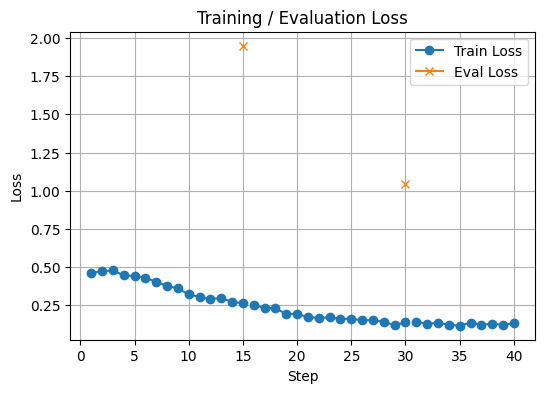

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# แปลง log_history เป็น DataFrame เพื่อจัดการง่าย
df = pd.DataFrame(trainer.state.log_history)

# ===== กราฟ Loss =====
plt.figure(figsize=(6,4))
plt.plot(df["step"], df["loss"], label="Train Loss", marker="o")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Eval Loss", marker="x")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training / Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ===== กราฟ Accuracy =====
if "eval_accuracy" in df.columns or "accuracy" in df.columns:
    plt.figure(figsize=(6,4))
    acc_col = "eval_accuracy" if "eval_accuracy" in df.columns else "accuracy"
    plt.plot(df["step"], df[acc_col], label="Eval Accuracy", color="green", marker="x")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy over Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # เช่น 20251004_1658
save_dir = f"lora_model_val_final_{timestamp}"

os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"✅ Model saved to: {save_dir}")

✅ Model saved to: lora_model_val_final_20251006_012140


#### ประเมินกับ Test Set (Final Evaluation)

ถ้าคุณมีชุดข้อมูล test (ที่ไม่เคยใช้เลย)
ให้รัน trainer.evaluate(test_dataset) เพื่อดู performance ที่แท้จริง

In [21]:
final_eval = trainer.evaluate(converted_dataset_test)
print(final_eval)

{'eval_loss': 0.9748682379722595, 'eval_runtime': 311.97, 'eval_samples_per_second': 2.927, 'eval_steps_per_second': 1.465, 'epoch': 0.07455731593662628}


In [22]:
import re, torch, pandas as pd
from tqdm import tqdm

# ===== 1) ใช้แค่ 30 ตัวแรก =====
subset = blind_test_hf.select(range(30))

CLASS_SET = {
    "Chest_Changes","Degenerative_Infectious","Higher_Density",
    "Inflammatory_Pneumonia","Lower_Density","Mediastinal_Changes",
    "Normal","Obstructive",
}

instruction = (
    "Describe the chest X-ray using precise clinical terms. "
    "Identify one main diagnostic category from: "
    "Chest_Changes, Degenerative_Infectious, Higher_Density, "
    "Inflammatory_Pneumonia, Lower_Density, Mediastinal_Changes, "
    "Normal, or Obstructive."
)

def extract_class_strict(text: str):
    if not isinstance(text, str) or not text.strip():
        return None
    # 1) จับจาก "Class: <ชื่อคลาส>" ก่อน (multi-line, case-insensitive)
    m = re.search(r"(?im)^\s*Class\s*:\s*([A-Za-z_]+)", text)
    if m:
        cand = m.group(1)
        # ไม่สนพิมพ์เล็กใหญ่ แต่คืนชื่อมาตรฐาน
        for cls in CLASS_SET:
            if cand.lower() == cls.lower():
                return cls
        return None
    # 2) Fallback: ถ้าจำเป็นจริง ๆ ค่อยสแกนทั้งข้อความ (เลี่ยง prompt echo)
    for cls in sorted(CLASS_SET, key=str.lower):
        if re.search(rf"\b{re.escape(cls)}\b", text, flags=re.IGNORECASE):
            return cls
    return None

rows = []
correct = total = 0

for i, example in enumerate(subset):
    image = example["image"]

    # label จริงมาจาก __class__
    true_class = example["__class__"]

    # image_id (ถ้าไม่มีคอลัมน์ id ใช้ดัชนี i)
    image_id = example.get("id", i)

    # [changed] ส่ง instruction เดียวกันทุกภาพเข้า chat template
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction},
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to(model.device)

    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            use_cache=True,
            return_dict_in_generate=False,
            output_scores=False,
        )

    # ตัด prompt ออก: ใช้ความยาว input_ids เป็นตัวแบ่ง
    input_len = inputs["input_ids"].shape[1]
    gen_ids = out_ids[0][input_len:]                 # <-- เฉพาะที่โมเดลสร้างใหม่
    decoded_text = tokenizer.decode(gen_ids, skip_special_tokens=True)
    
    pred_class = extract_class_strict(decoded_text)
    print(f"id: {image_id}, true_class : {true_class}, pred_class : {pred_class}")

    # อัปเดต accuracy (นับเมื่อ true_class เป็นคลาสใน ALLOWED_CLASSES)
    if true_class in CLASS_SET:
        total += 1
        if pred_class == true_class:
            correct += 1

    rows.append({
        "image_id": image_id,
        "pred_class": pred_class,
        "true_class": true_class,
        "decoded_text": decoded_text,
    })

# ===== 2) สรุป accuracy =====
acc = correct / total if total > 0 else 0.0
print(f"\n✅ Manual eval_accuracy on 30 samples: {acc:.4f} ({correct}/{total})")

# ===== 3) เซฟ CSV =====
df = pd.DataFrame(rows, columns=["image_id", "pred_class", "true_class", "decoded_text"])
csv_path = f"vl_eval_predictions_final.csv"
df.to_csv(csv_path, index=False, encoding="utf-8-sig")
print(f"💾 Saved CSV -> {csv_path}")

id: 0, true_class : Degenerative_Infectious, pred_class : Degenerative_Infectious
id: 1, true_class : Mediastinal_Changes, pred_class : Inflammatory_Pneumonia
id: 2, true_class : Mediastinal_Changes, pred_class : Inflammatory_Pneumonia
id: 3, true_class : Obstructive, pred_class : Higher_Density
id: 4, true_class : Higher_Density, pred_class : Higher_Density
id: 5, true_class : Obstructive, pred_class : Inflammatory_Pneumonia
id: 6, true_class : Inflammatory_Pneumonia, pred_class : Higher_Density
id: 7, true_class : Normal, pred_class : Normal
id: 8, true_class : Obstructive, pred_class : Higher_Density
id: 9, true_class : Degenerative_Infectious, pred_class : Higher_Density
id: 10, true_class : Normal, pred_class : Higher_Density
id: 11, true_class : Lower_Density, pred_class : Normal
id: 12, true_class : Inflammatory_Pneumonia, pred_class : Normal
id: 13, true_class : Normal, pred_class : Higher_Density
id: 14, true_class : Mediastinal_Changes, pred_class : Higher_Density
id: 15, tru